In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
from src.data_processing import process_file, compute_physical, process_file_from_wizard, split_experiments

folder_path = "data/Test_XH430W350_20240209/PWM_control/*.csv"

# List to store each processed dataframe
processed_dataframes = []

# Iterate over all CSV files in the folder
for file_path in glob.glob(folder_path):
    # Apply processing function to the dataframe
    processed_df = process_file_from_wizard(file_path)
    experiments_split = split_experiments(processed_df)
    
    # Store the processed dataframe in the list
    processed_dataframes.extend(experiments_split)

external_inertia = 0.0022421143208 # Msolo
Ra = 9.3756 # [Ohm]
kt = 2.6657
ke = 0.8594
ke = 3.75286

parameters = ke, kt, Ra, 0.080964165, 0.0665140867408596, 0.203719639, 0.04217117990939209, 0.0155818308

len(processed_dataframes)

108

In [17]:
import numpy as np

# Some pre-computations
new_dfs = []
for df in processed_dataframes:
    df['tau_U'] = (kt / Ra) * (df['U'] - ke * df['DXL_Velocity'])
    df['tau_I'] = df['DXL_Current'] * kt
    df['tau'] = df['tau_U']
    delta_t = np.diff(df['t'])
    delta_t = np.insert(delta_t, 0, 0.0001)
    df['delta_t'] = delta_t

    # Calculate Δx (change in position)
    delta_x = np.diff(df['DXL_Position'])
    delta_x = np.insert(delta_x, 0, 0)
    df['delta_x'] = delta_x

    # Calculate velocity (Δx/Δt)
    df['Velocity_from_position'] = delta_x / delta_t

    # Acceleration computation
    delta_v = np.diff(df['Velocity_from_position'])
    delta_v = np.insert(delta_v, 0, 0)
    df['Acceleration_from_Velocity_from_position'] = delta_v / delta_t

    delta_v = np.diff(df['DXL_Velocity'])
    delta_v = np.insert(delta_v, 0, 0)
    df['Acceleration_from_DXL_Velocity'] = delta_v / delta_t

    new_dfs.append(df)
len(new_dfs)

108

In [22]:
import pickle

# Assuming `list_of_dataframes` is your list of pandas DataFrames
with open('dataframes_list2.pkl', 'wb') as file:
    pickle.dump(new_dfs, file)

In [ ]:
# In future codes, do this to load the dfs
with open('dataframes_list.pkl', 'rb') as file:
    processed_dataframes = pickle.load(file)

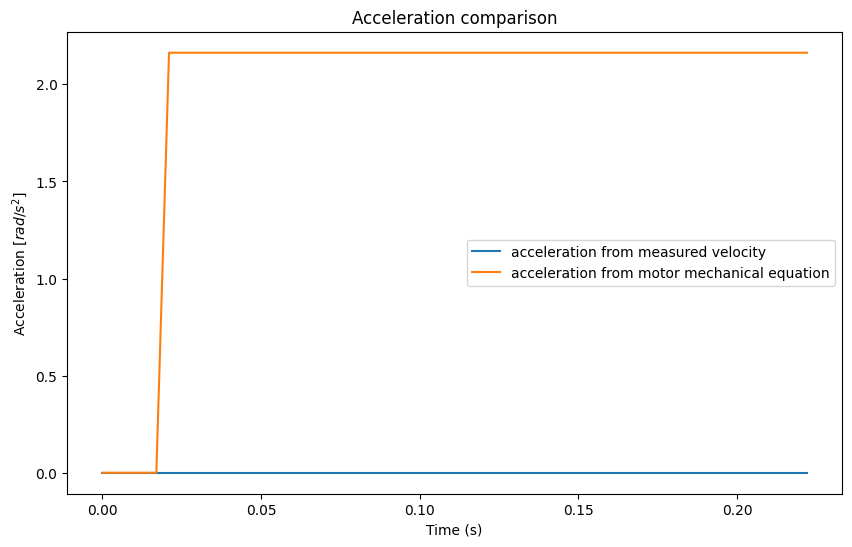

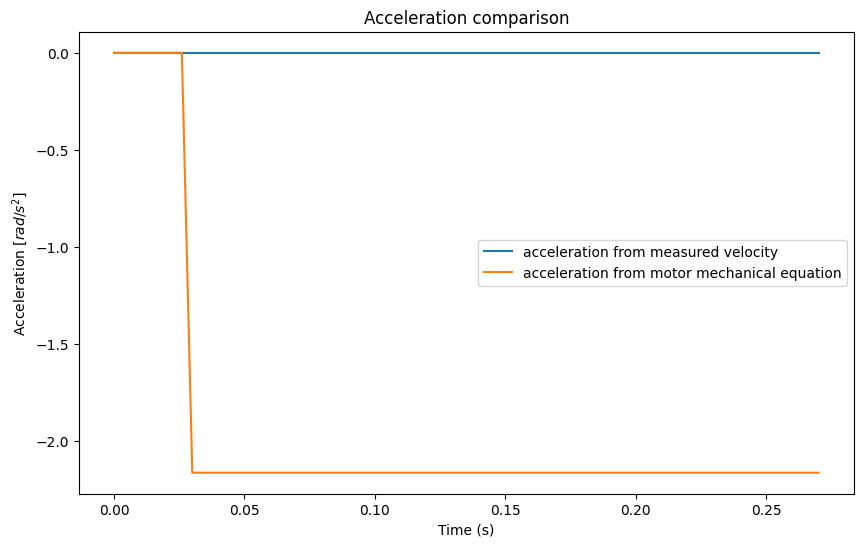

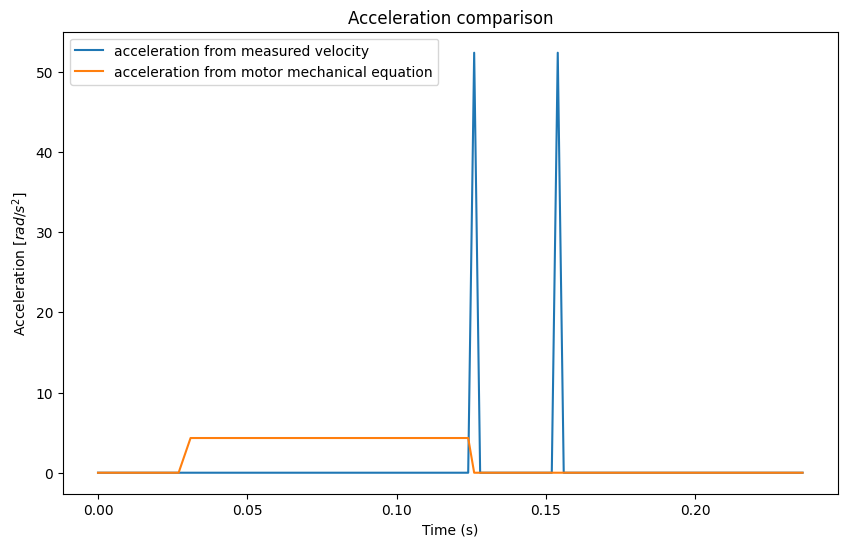

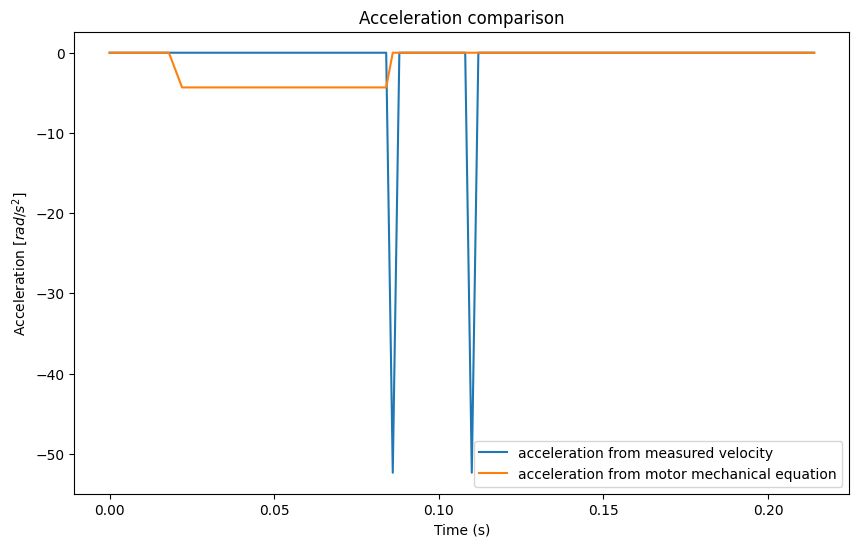

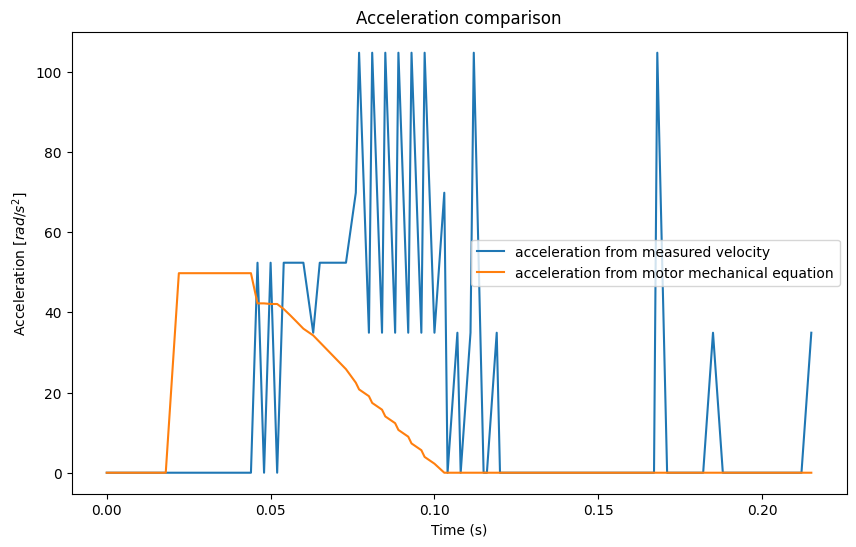

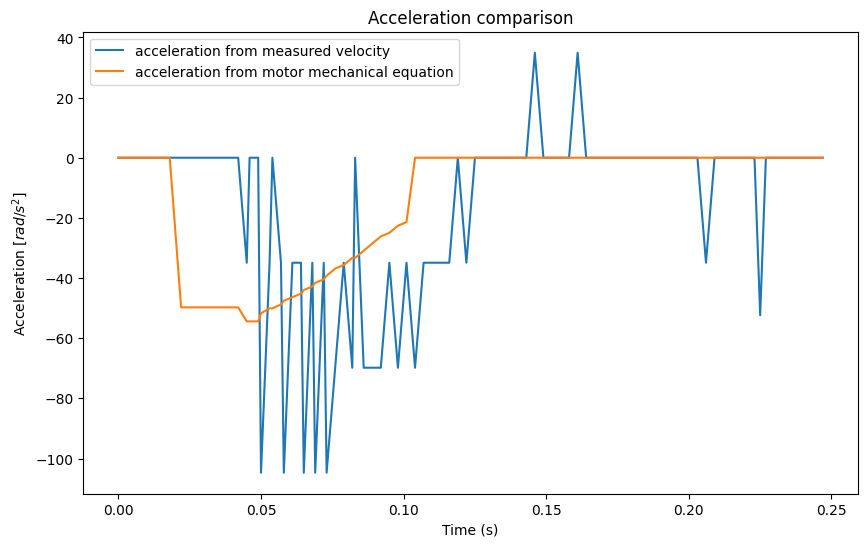

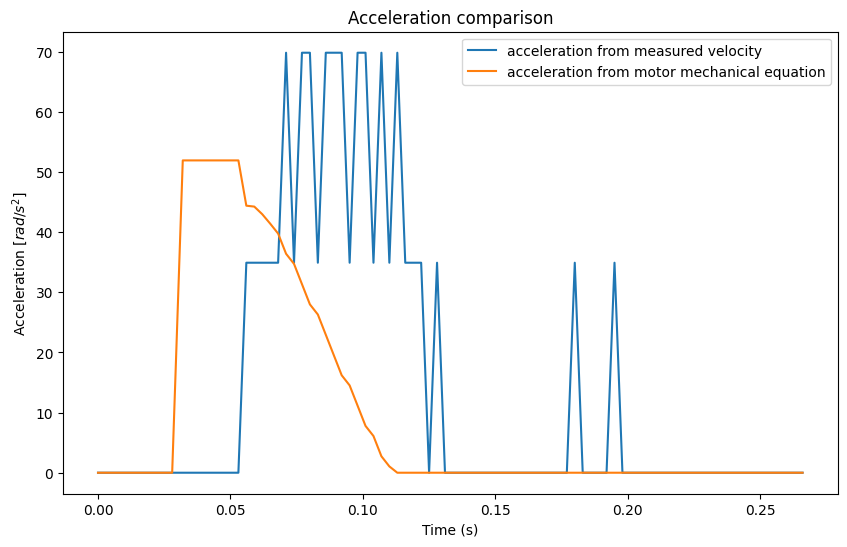

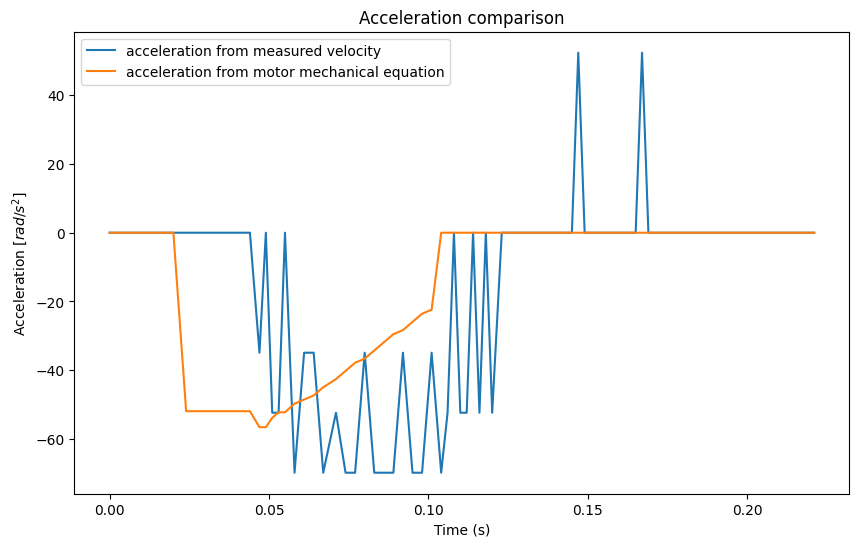

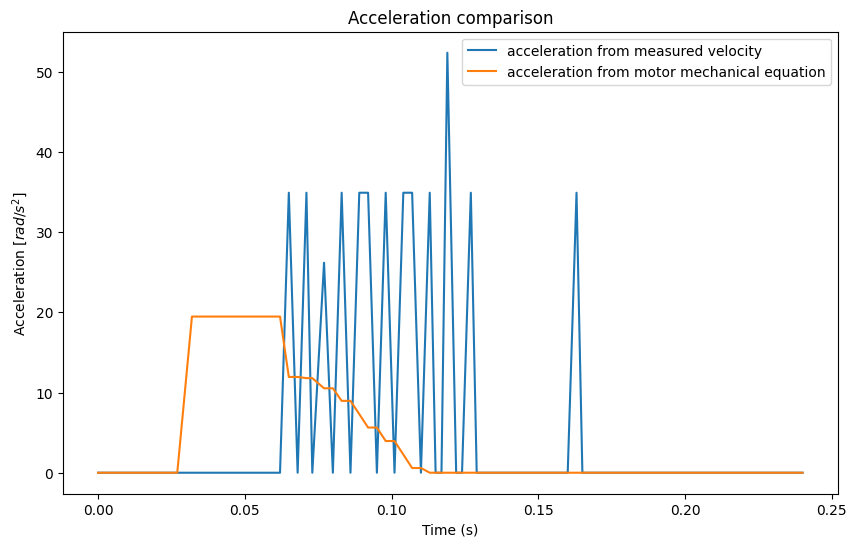

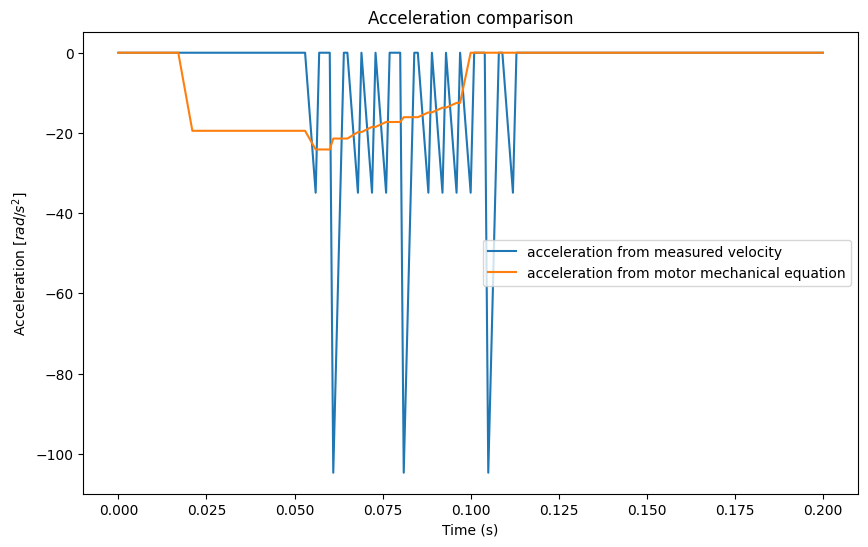

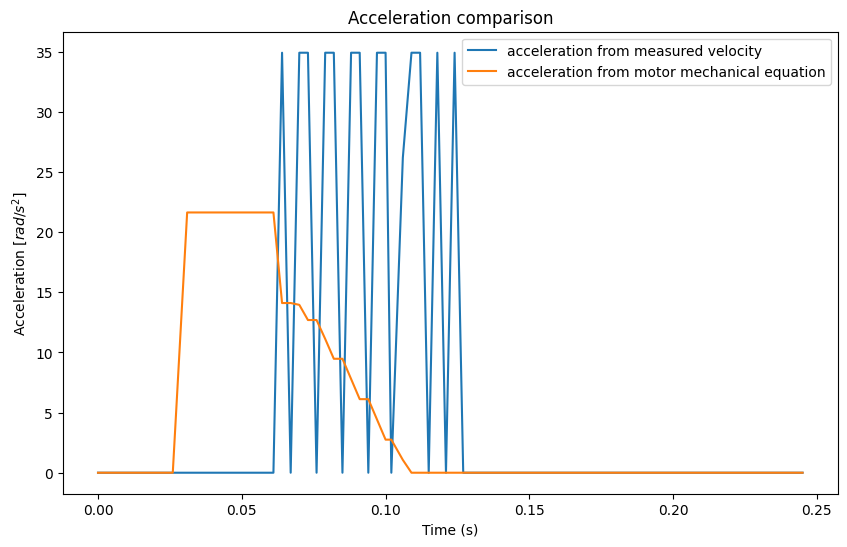

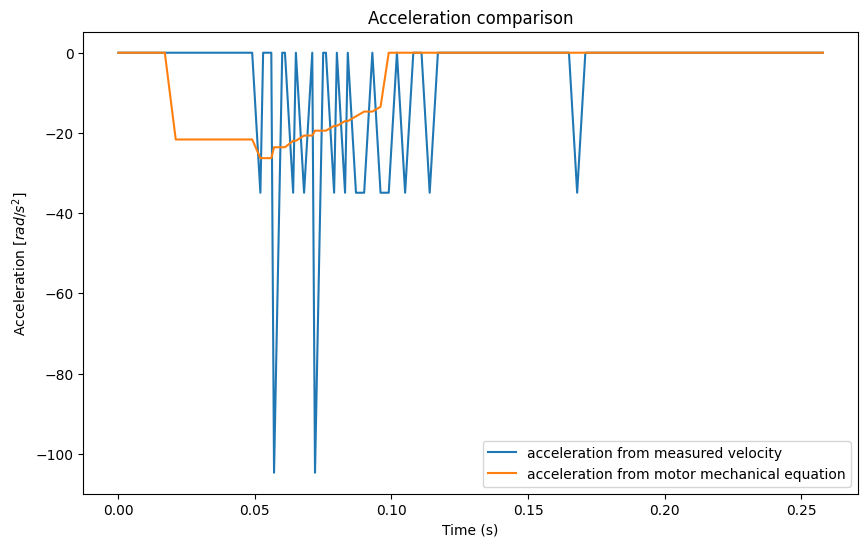

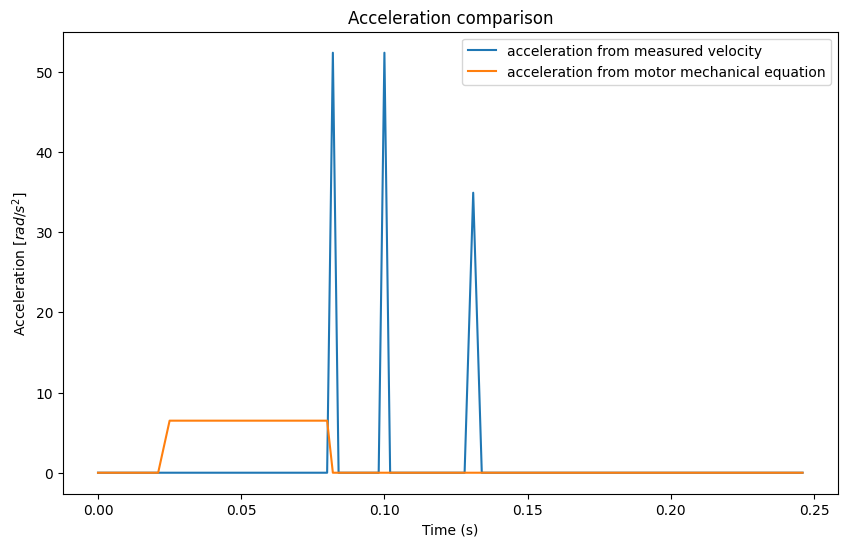

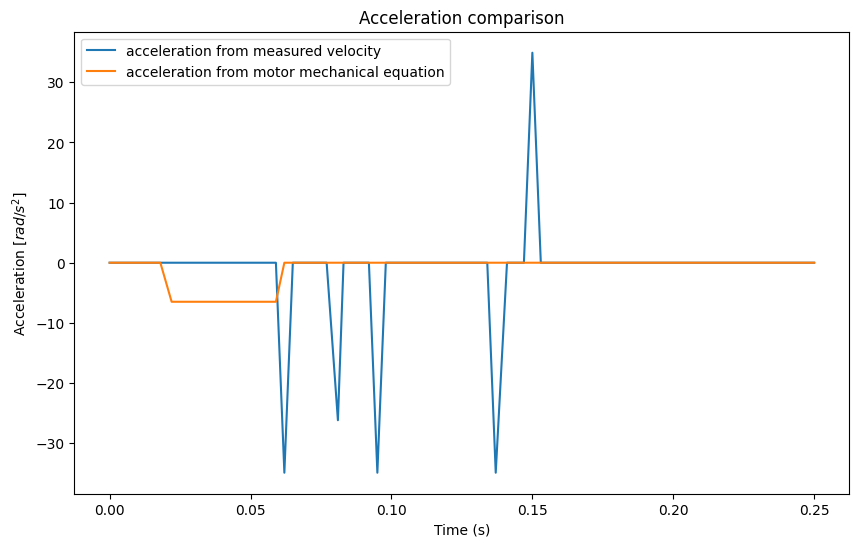

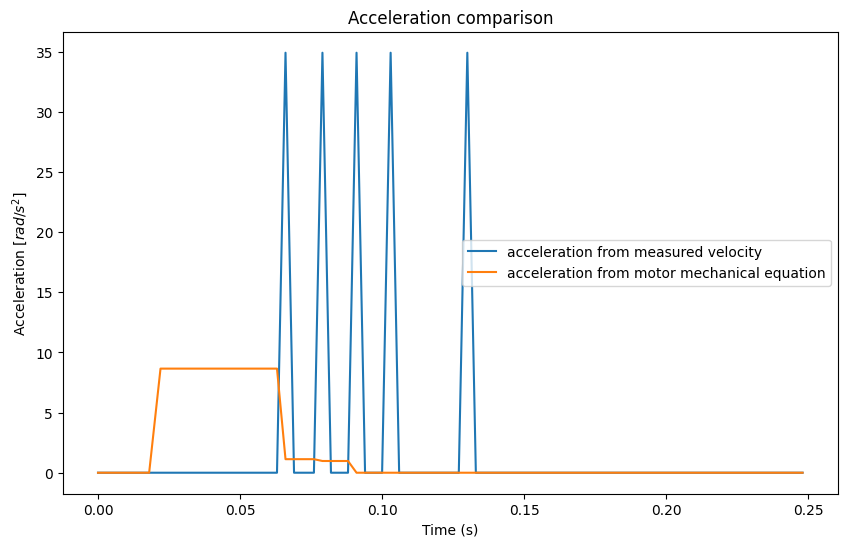

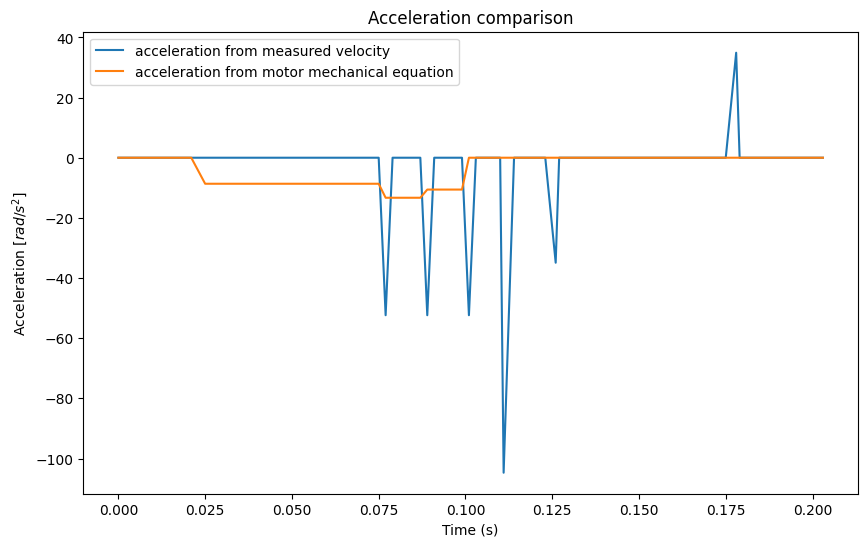

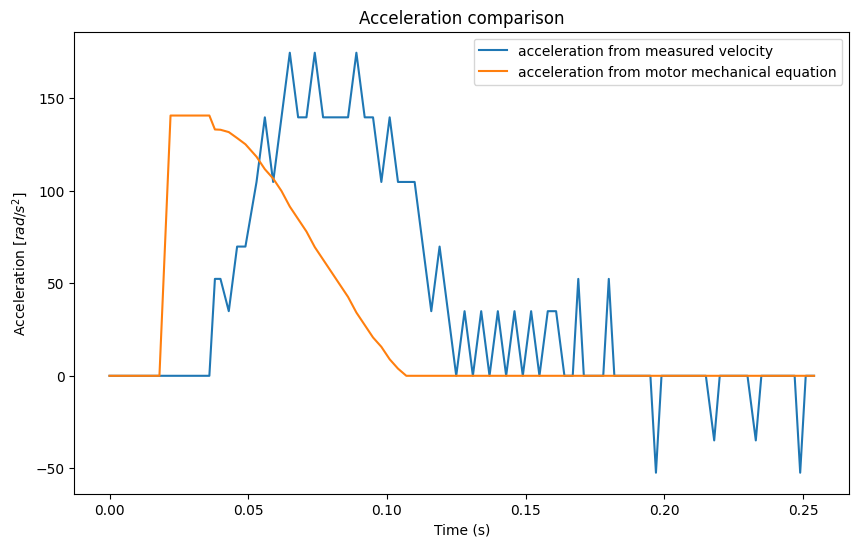

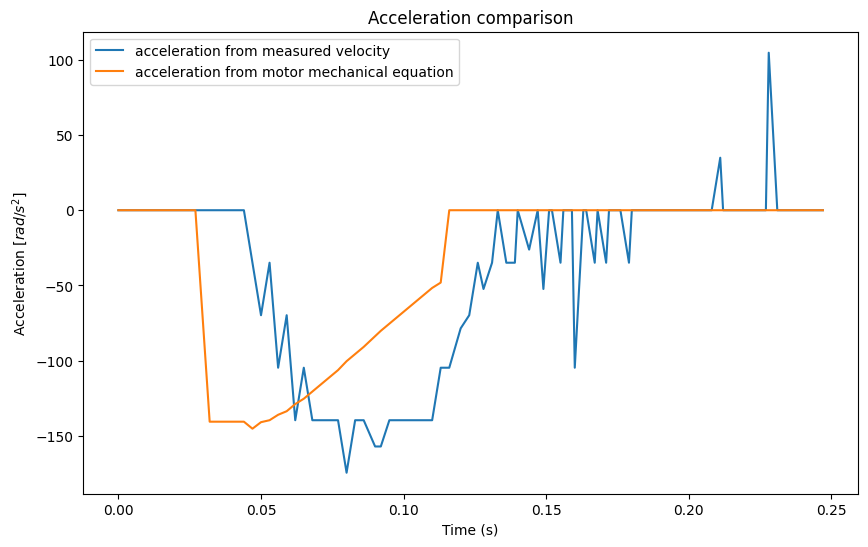

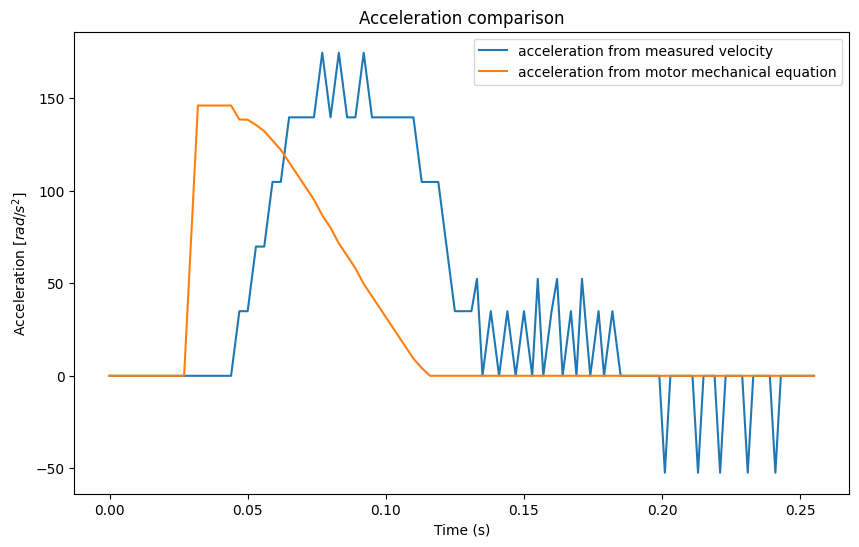

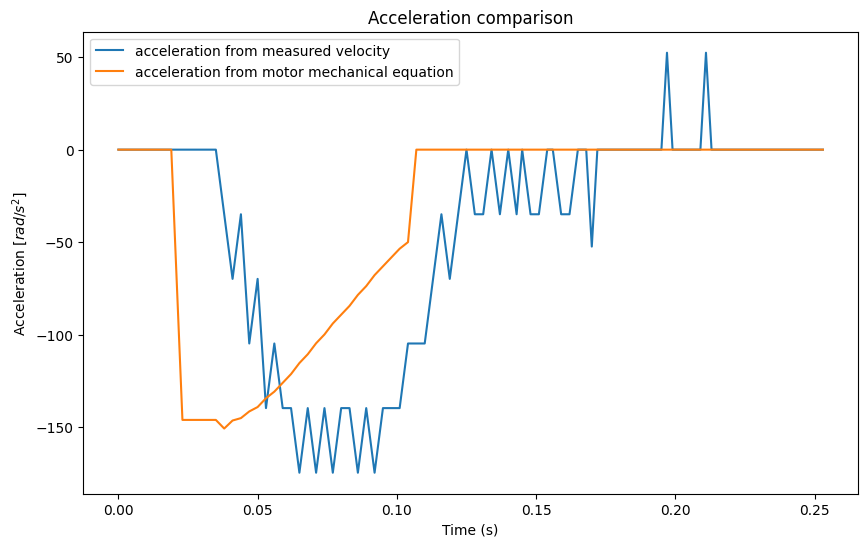

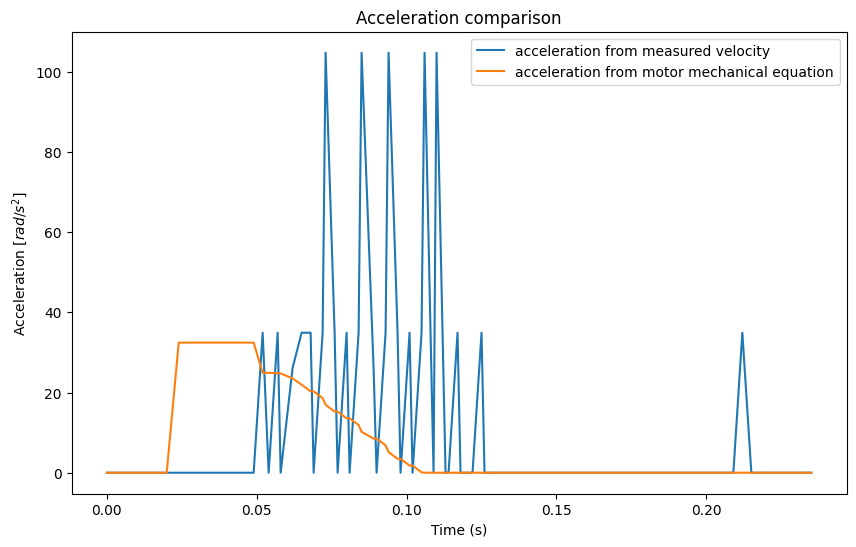

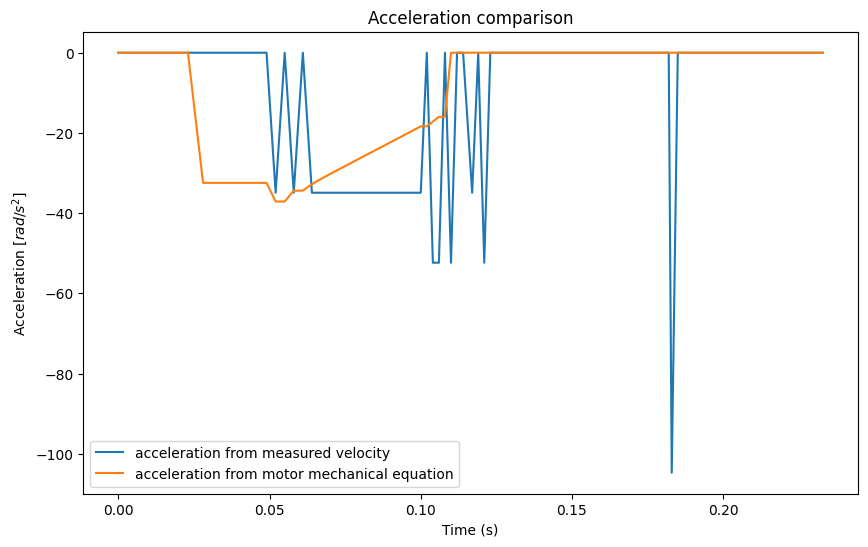

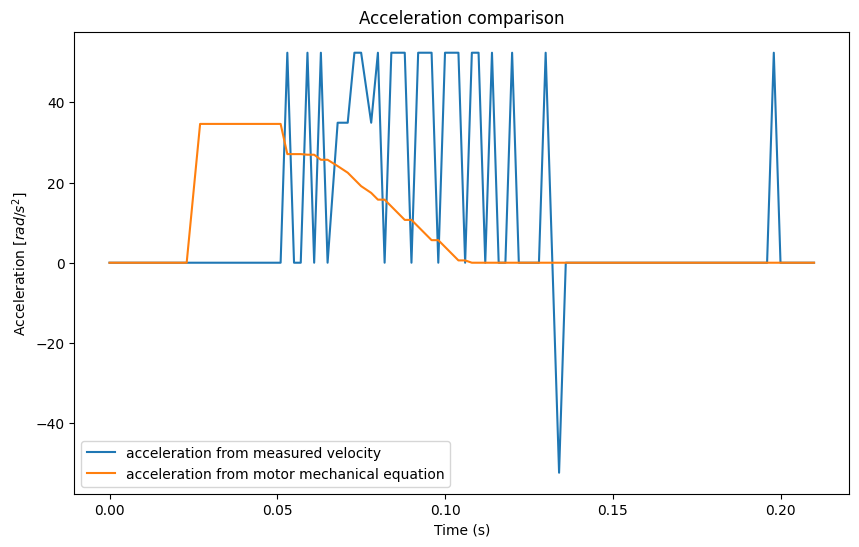

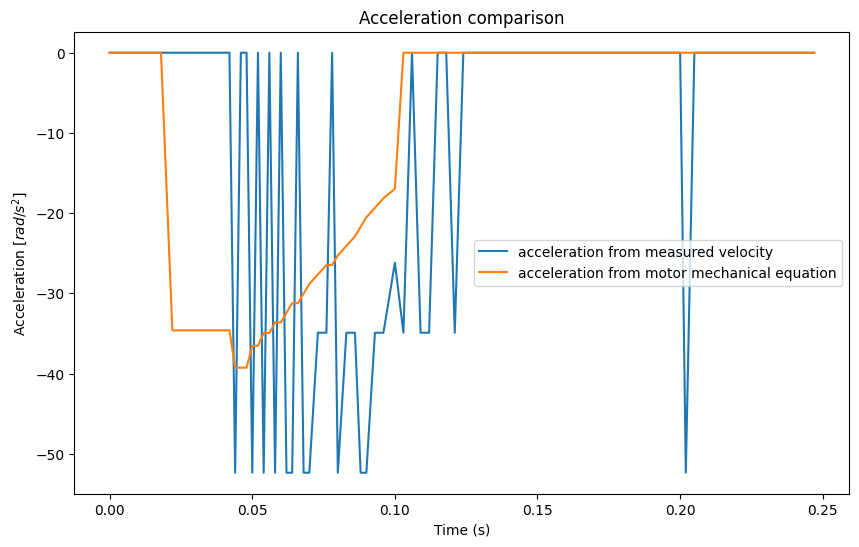

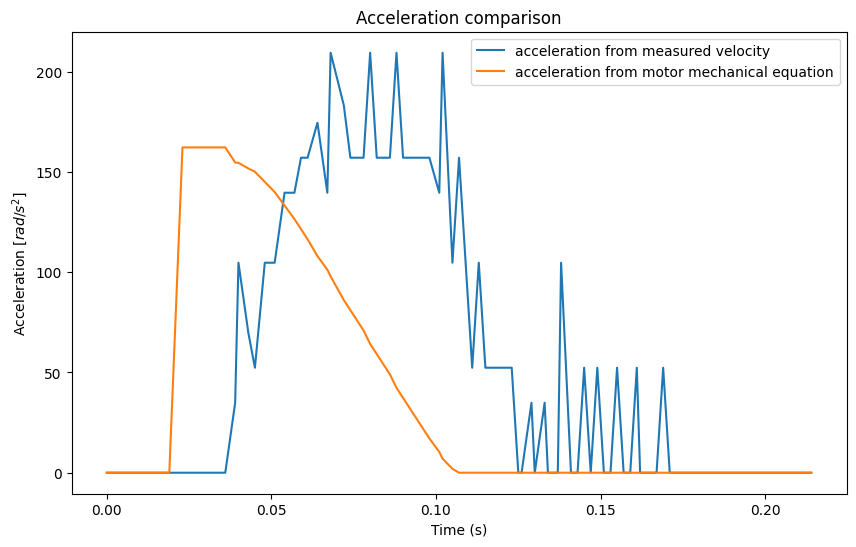

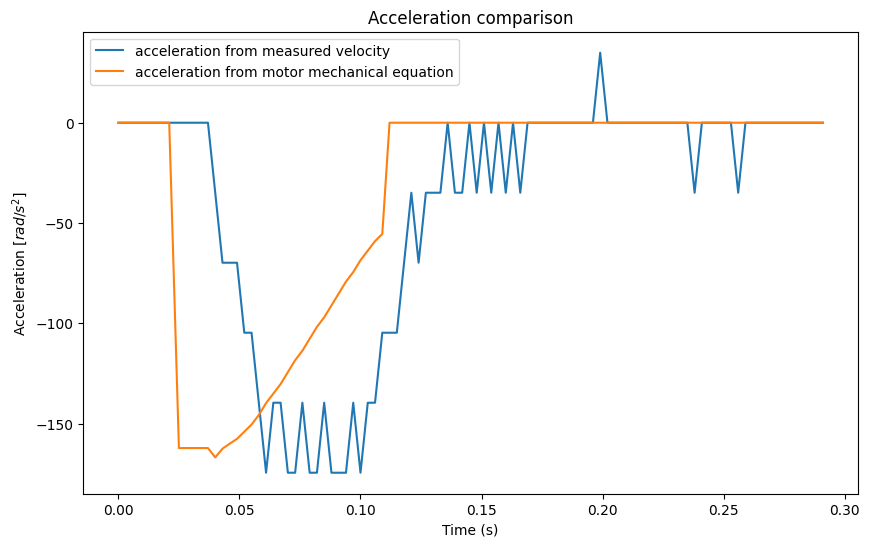

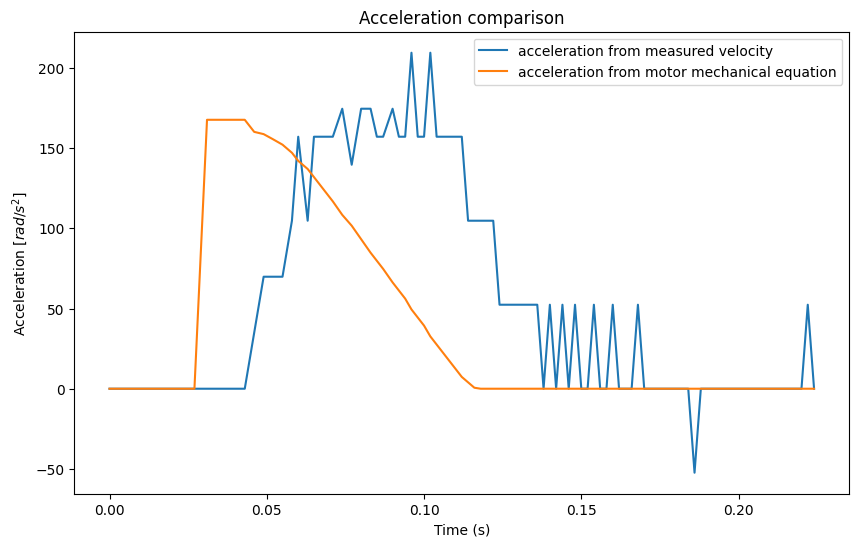

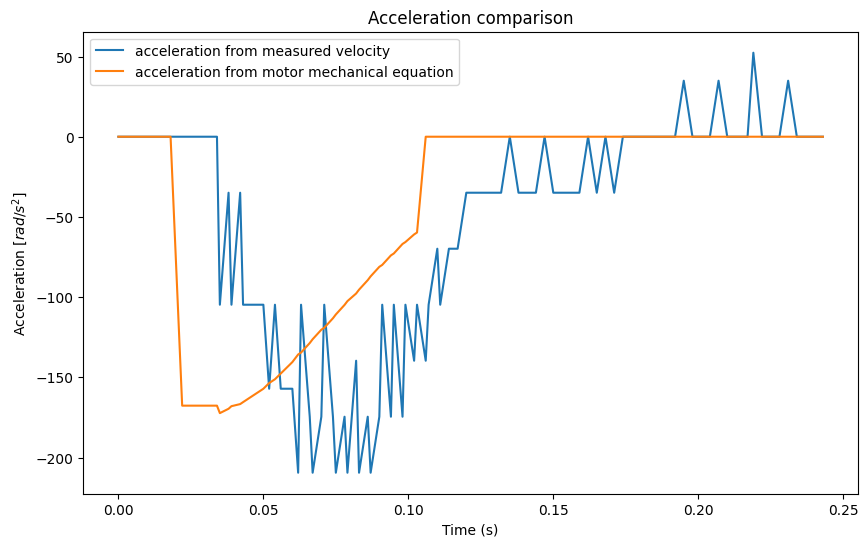

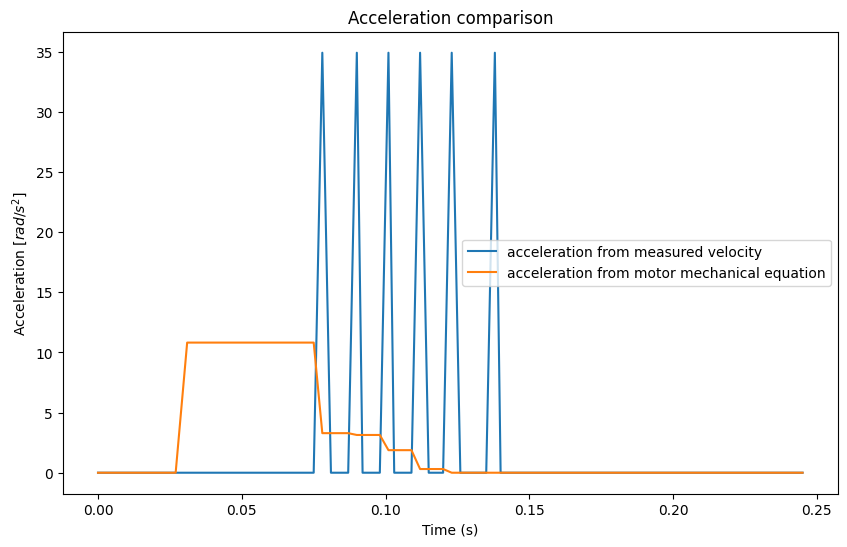

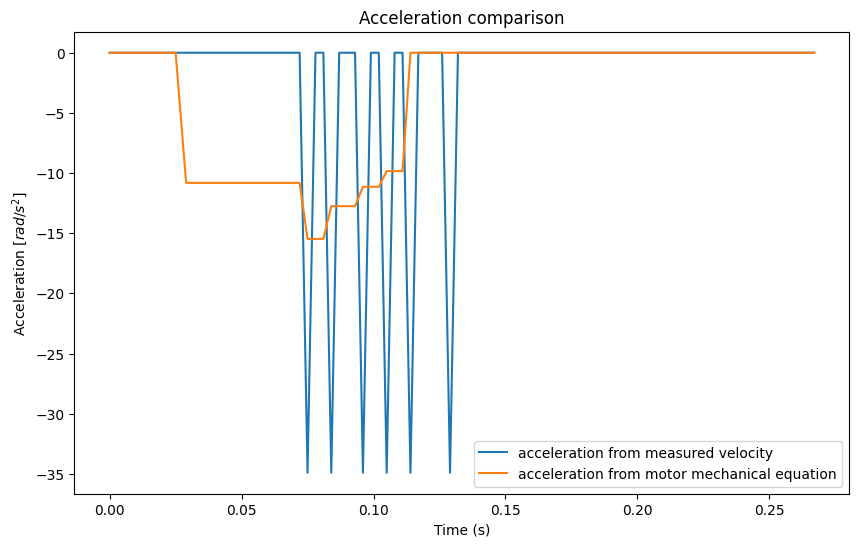

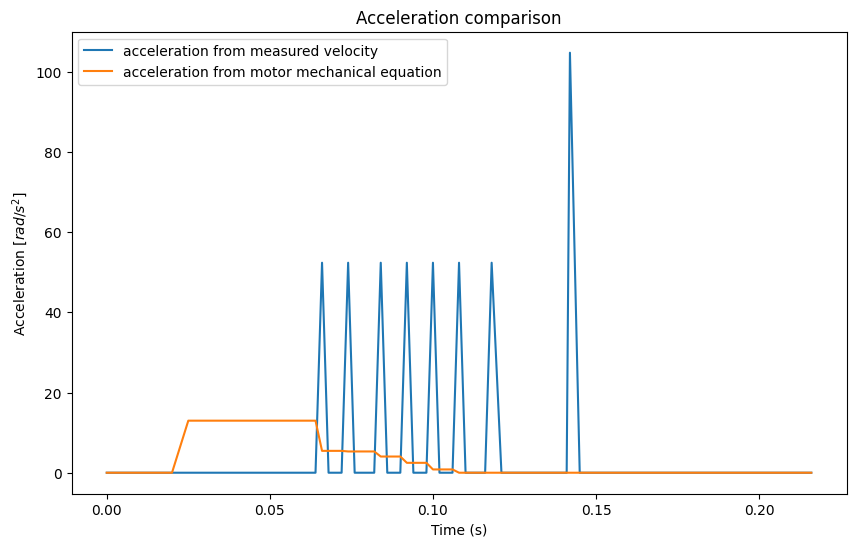

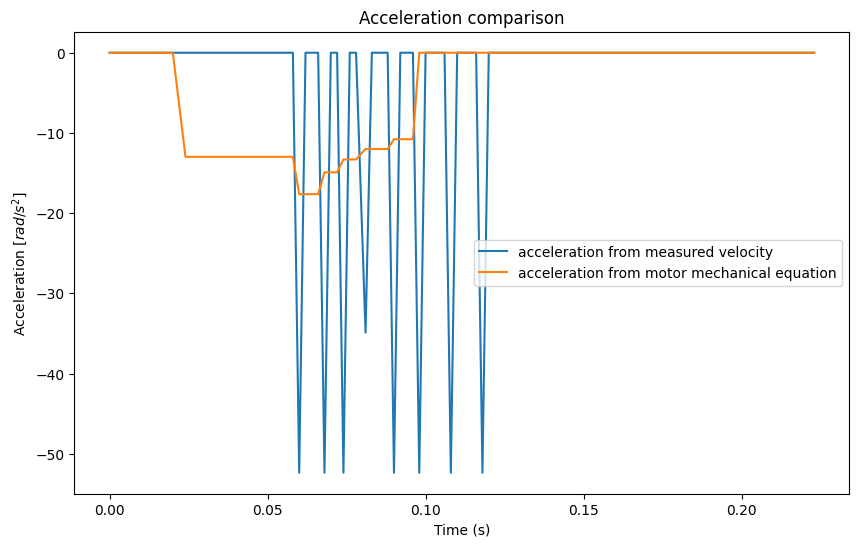

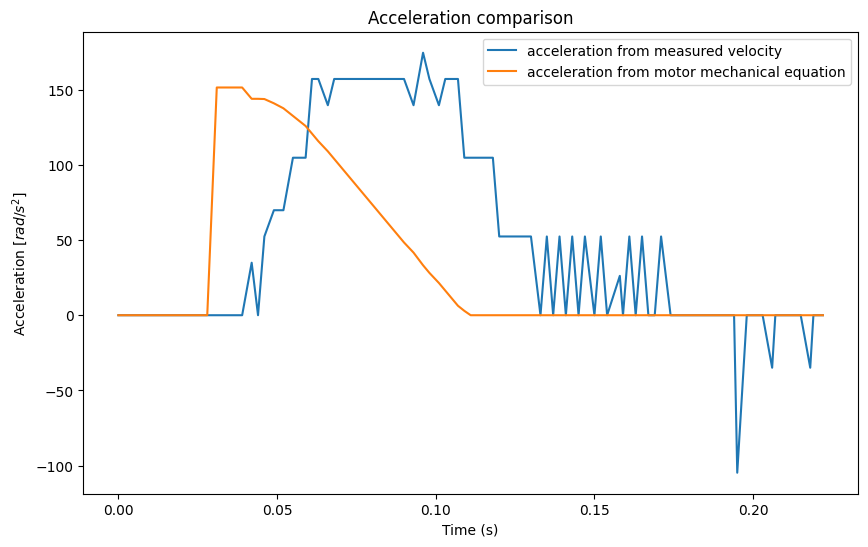

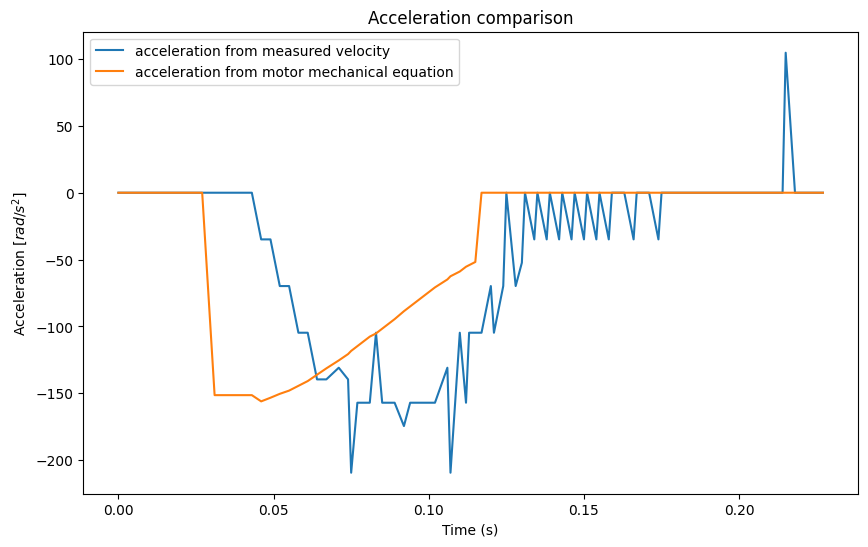

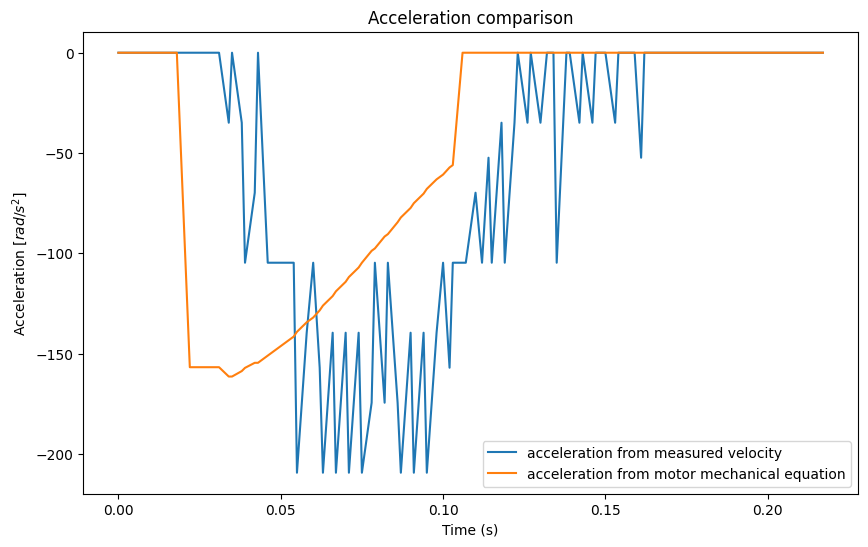

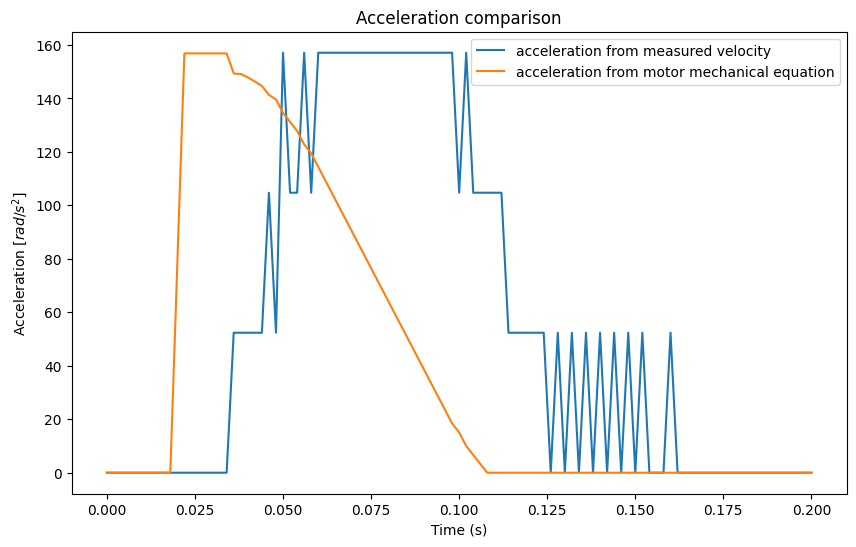

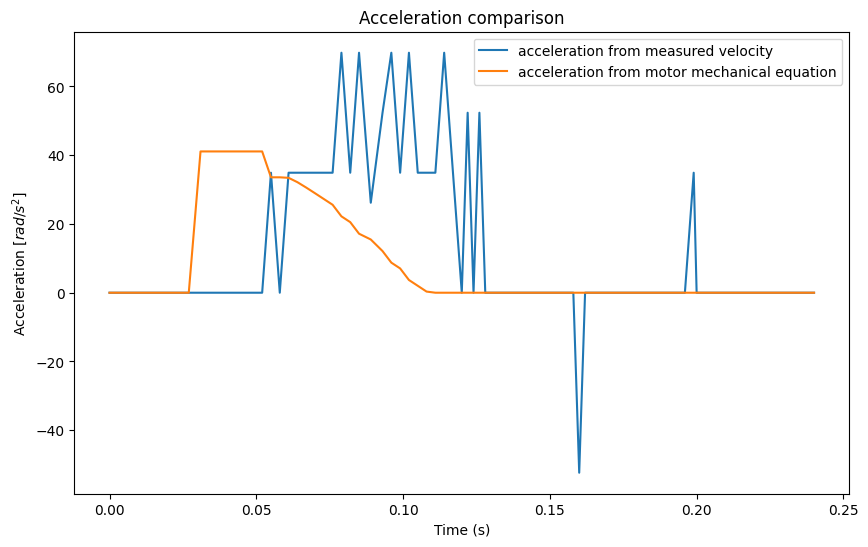

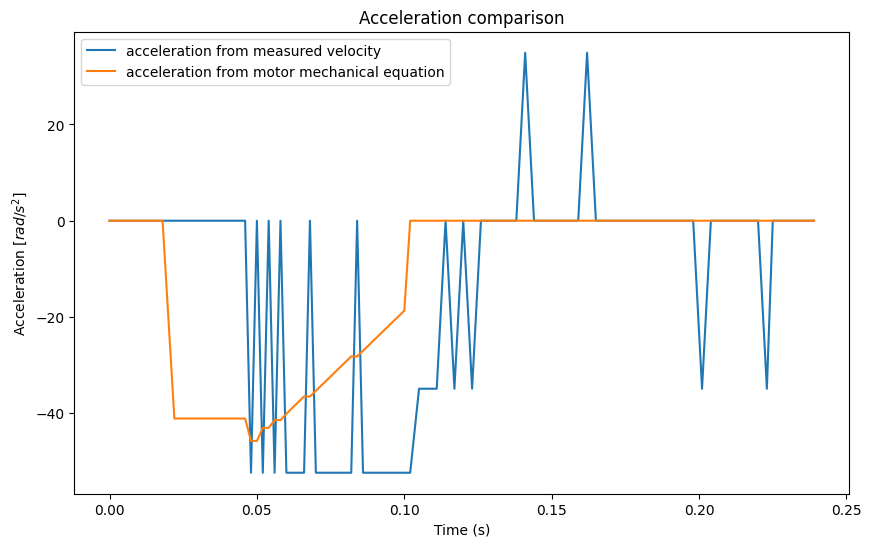

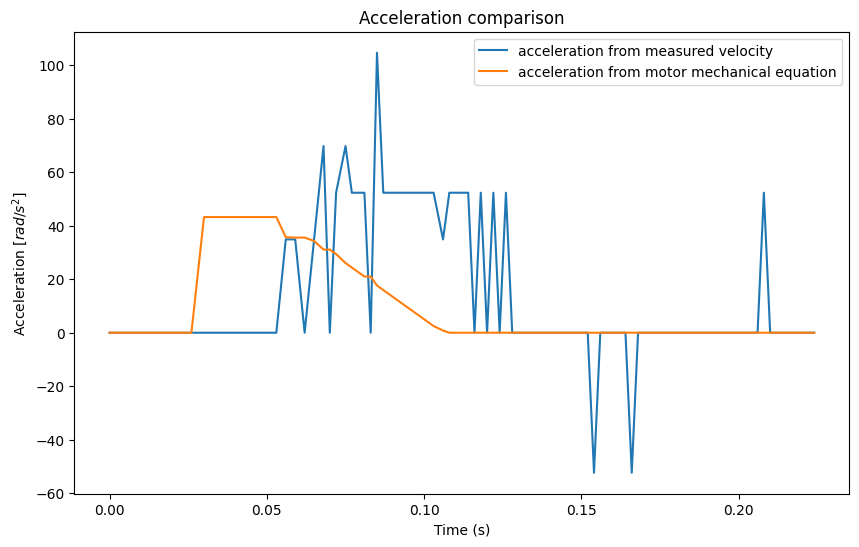

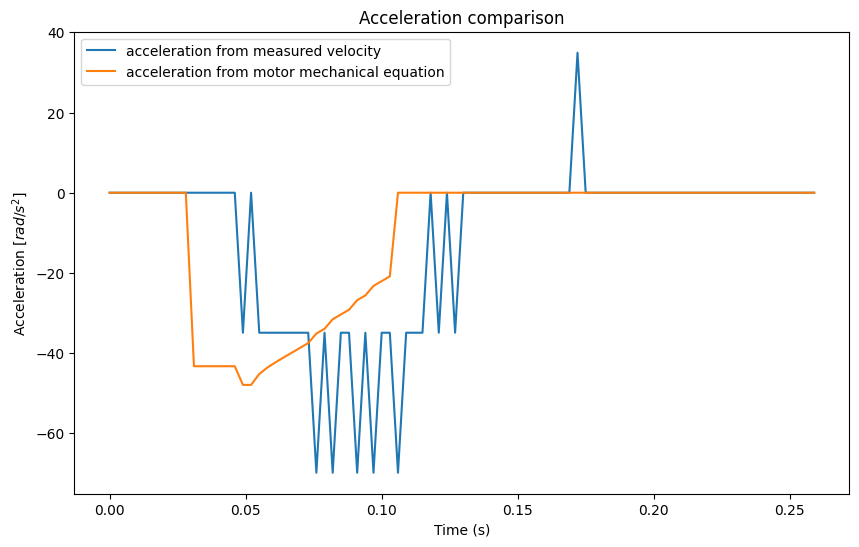

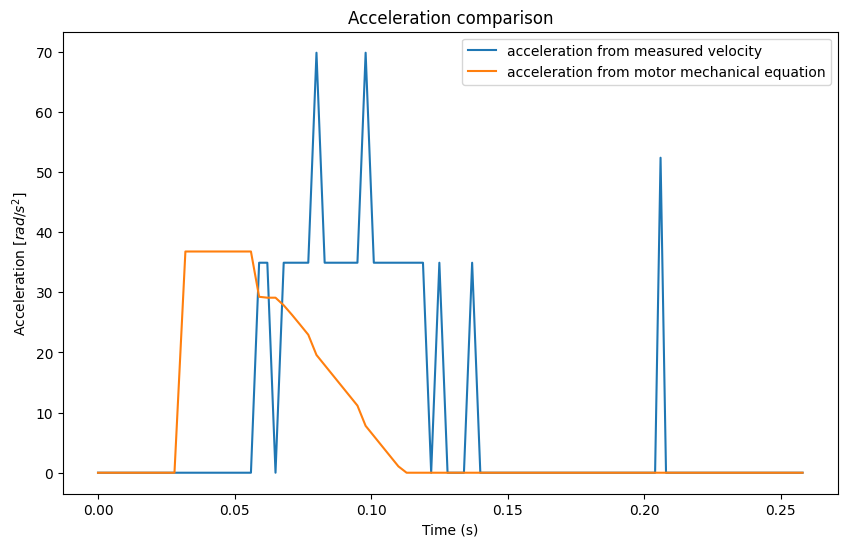

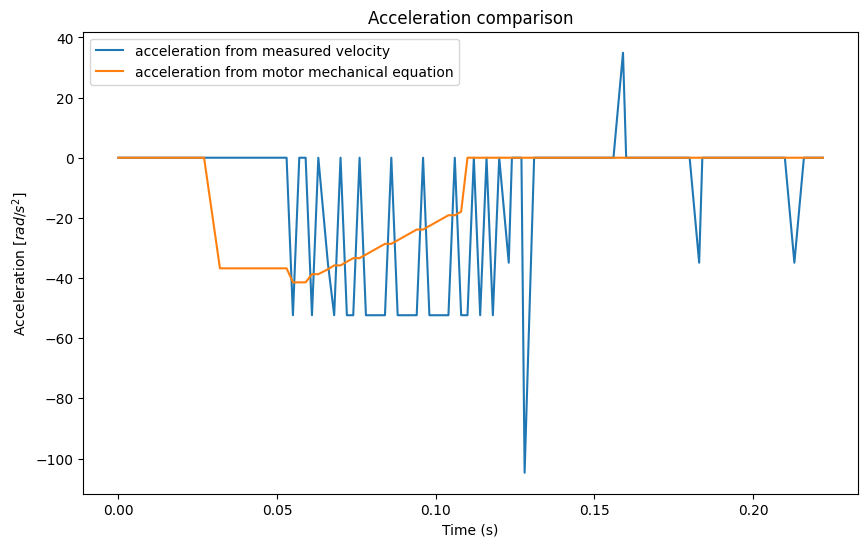

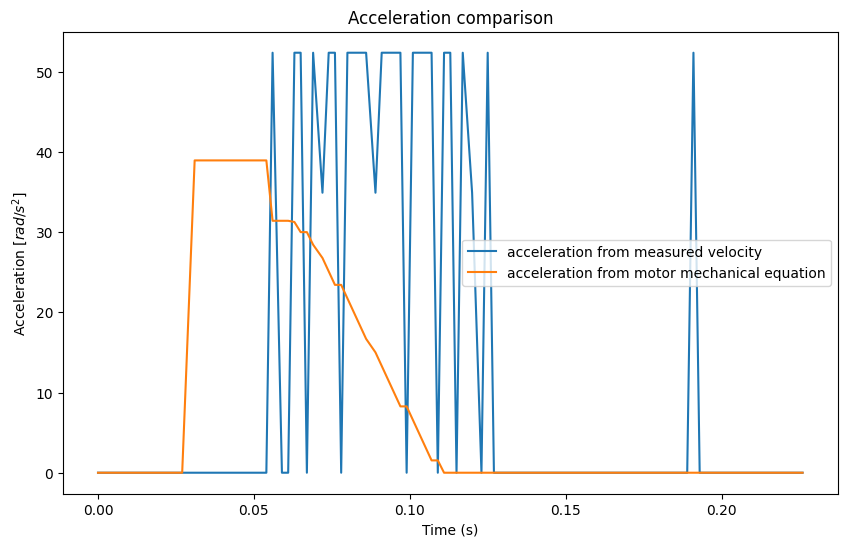

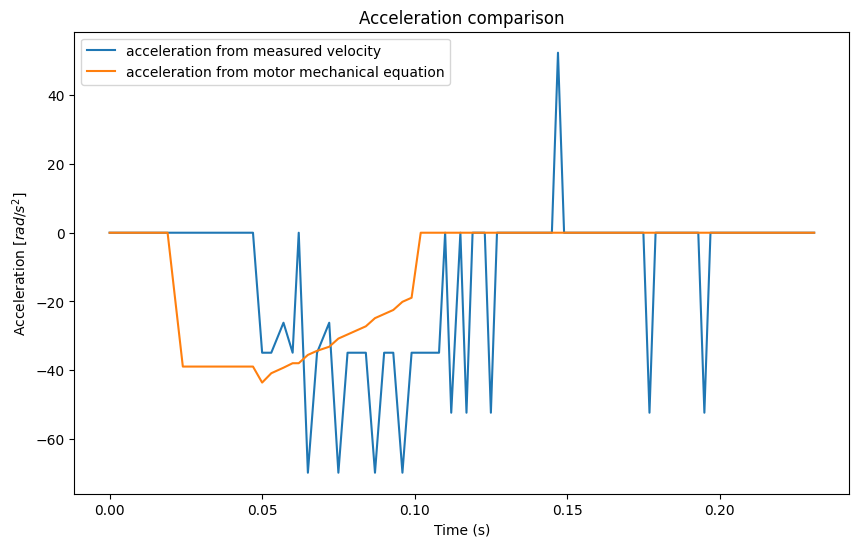

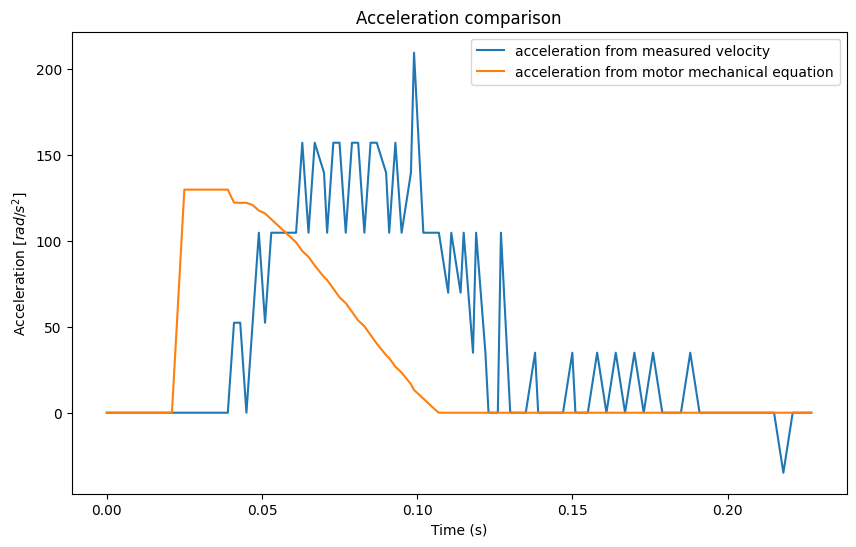

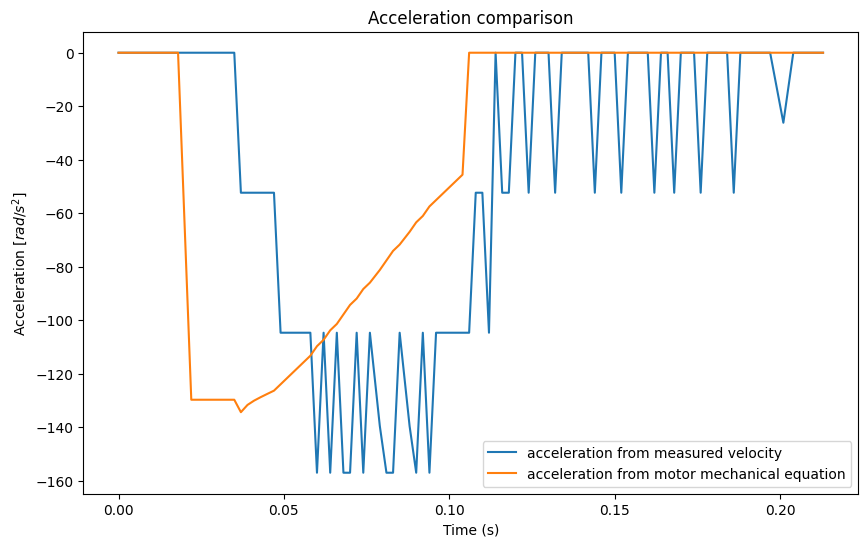

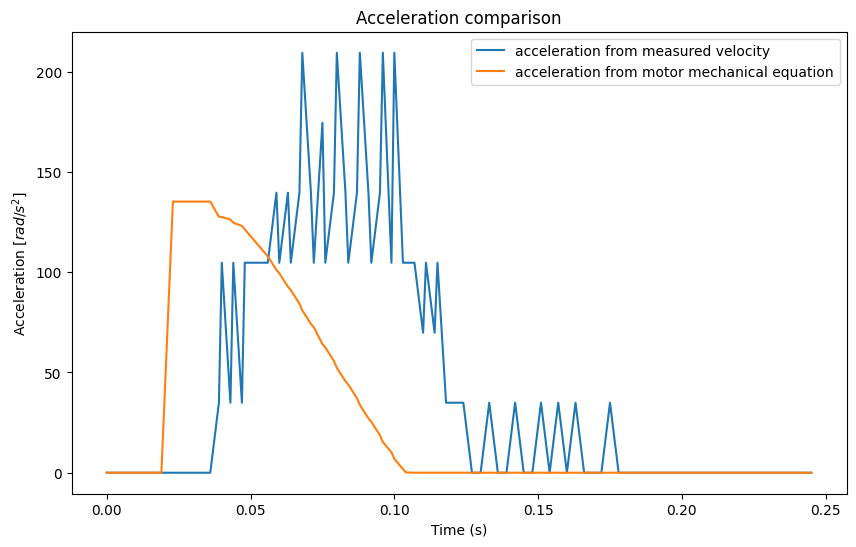

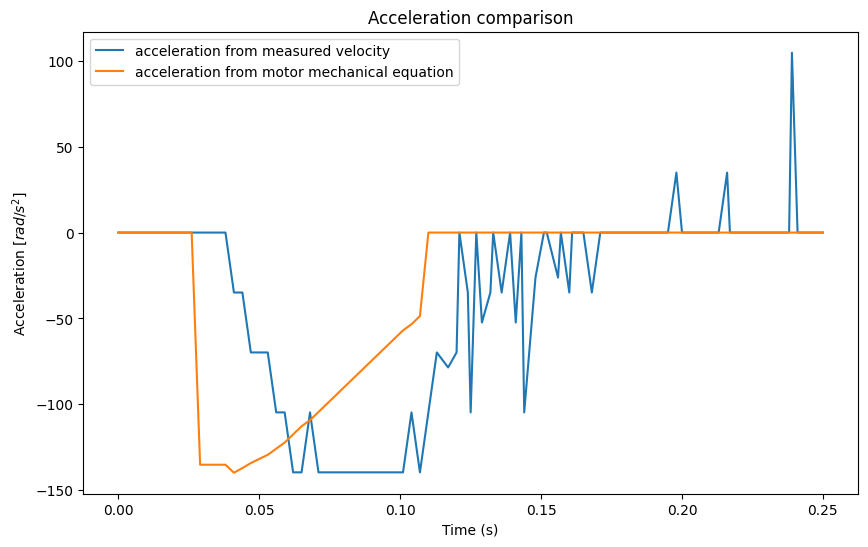

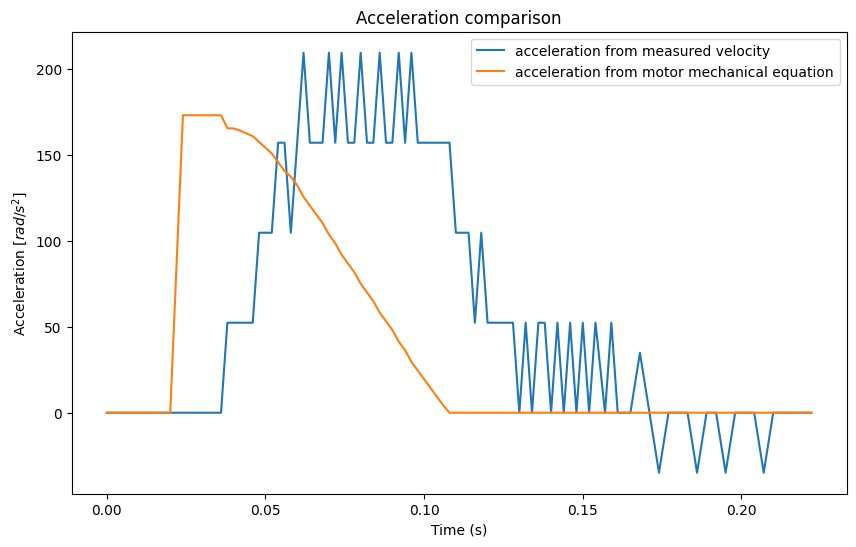

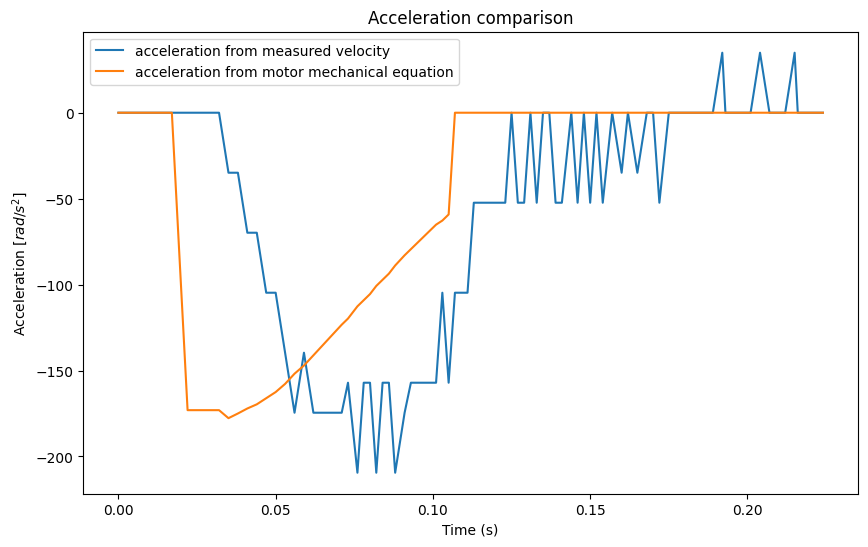

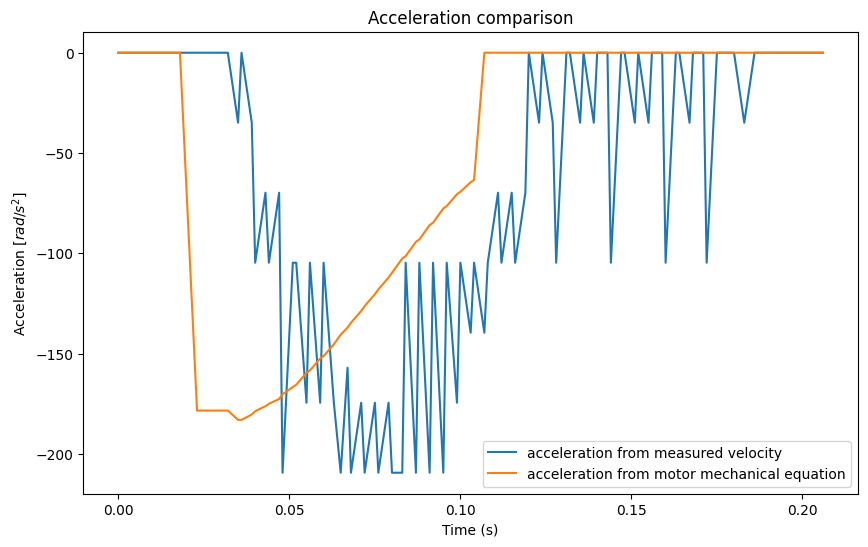

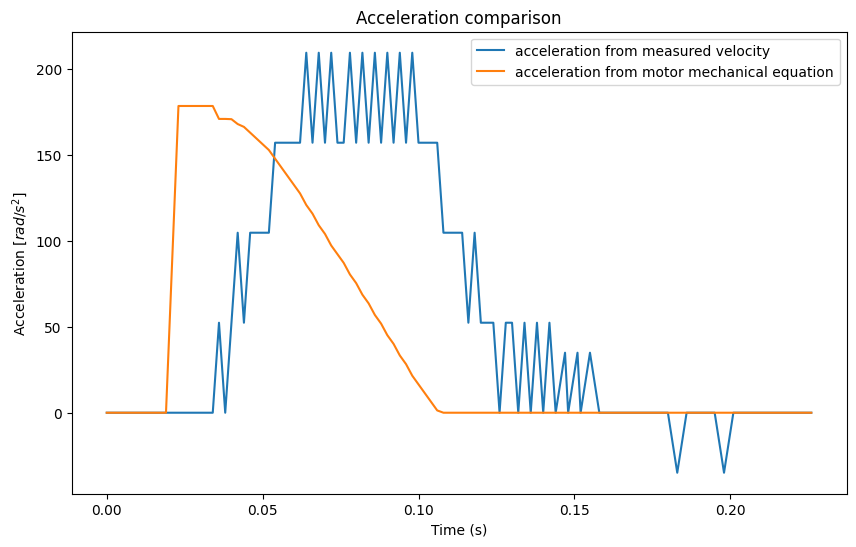

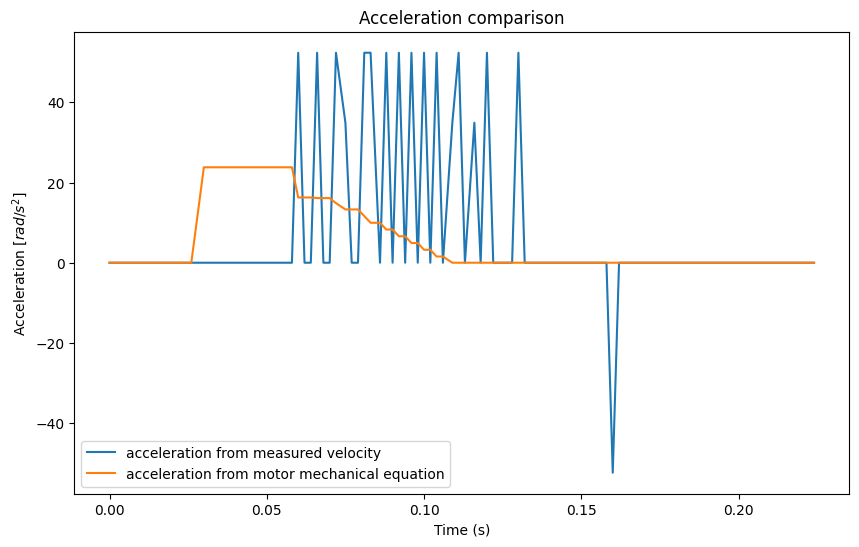

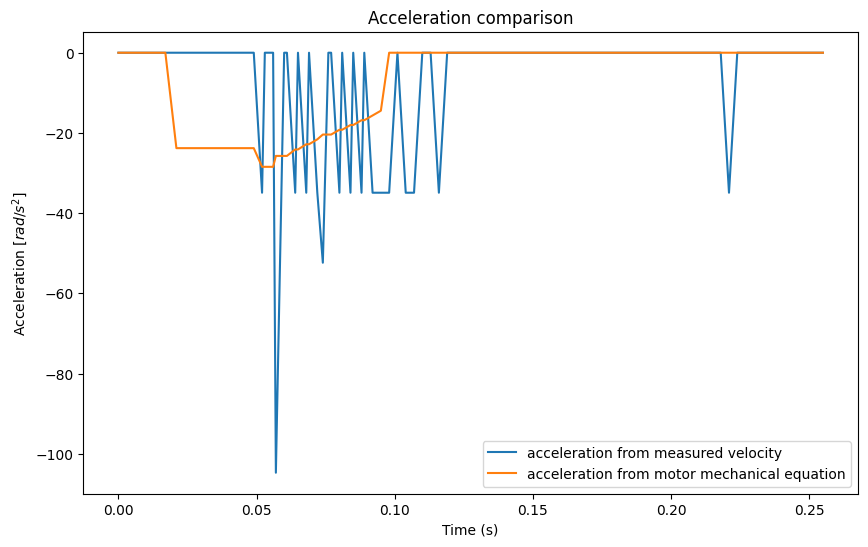

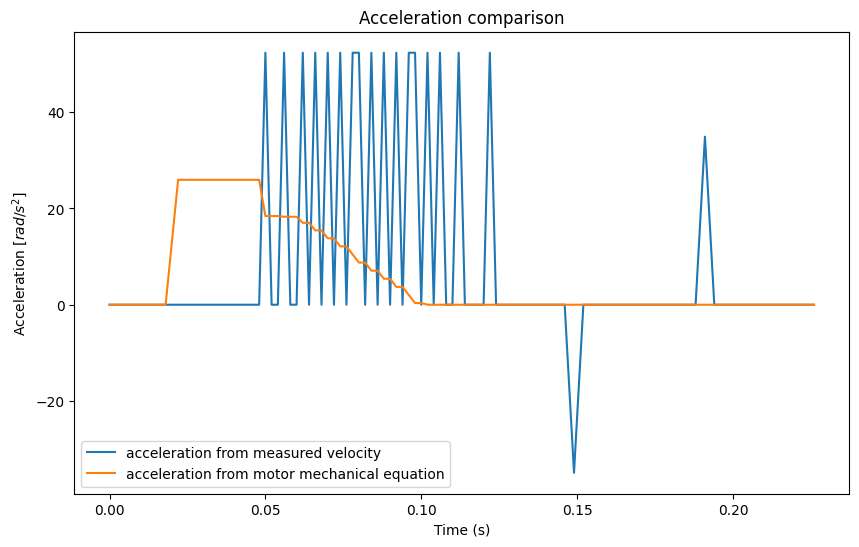

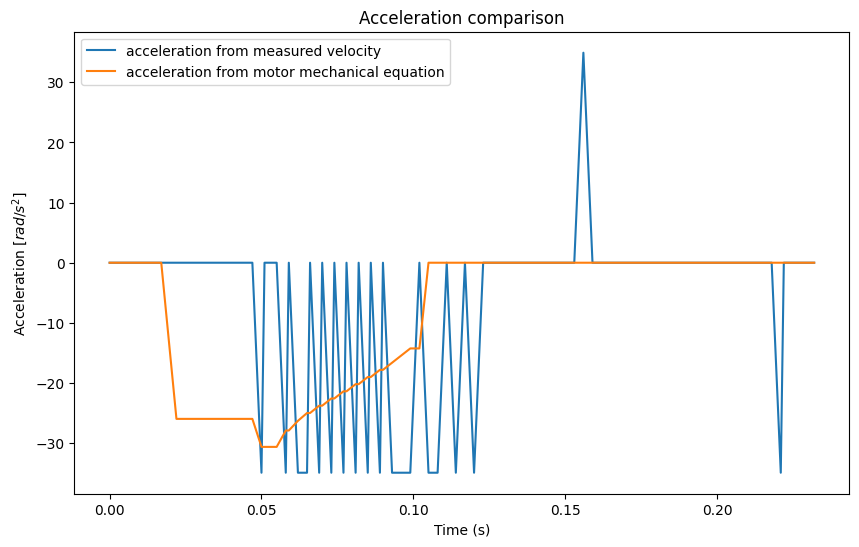

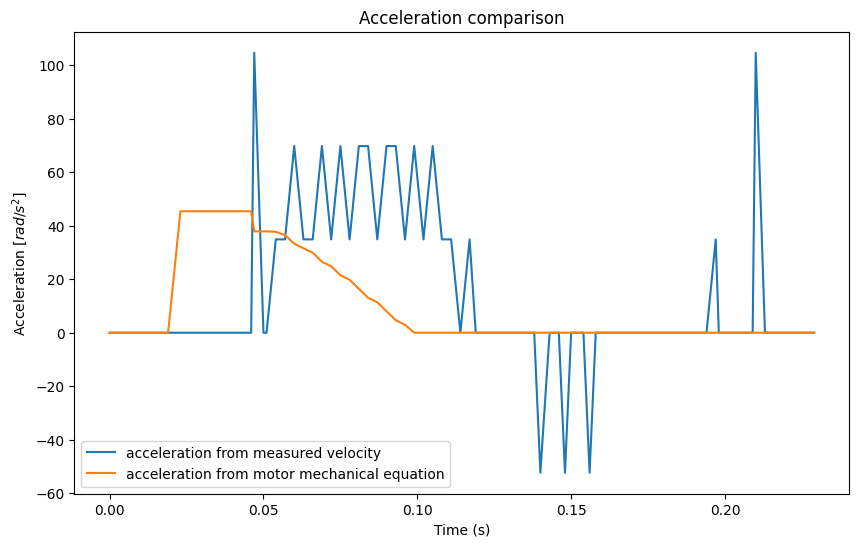

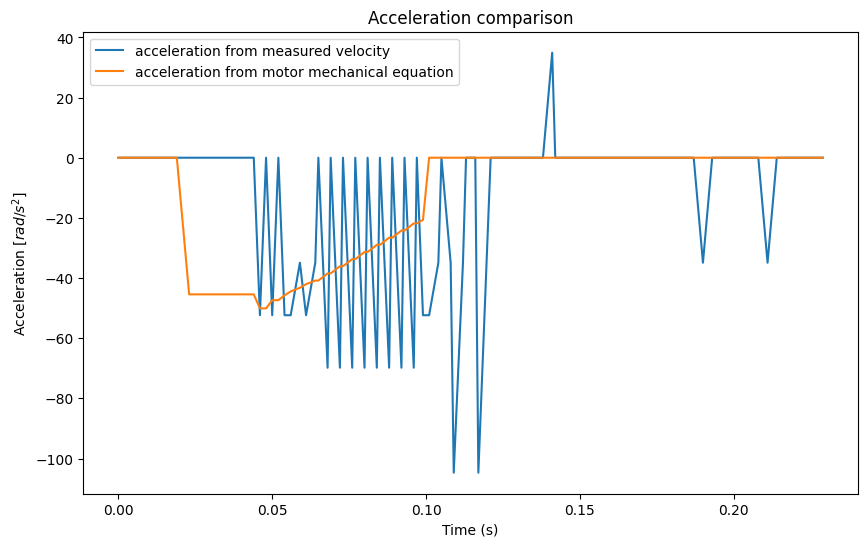

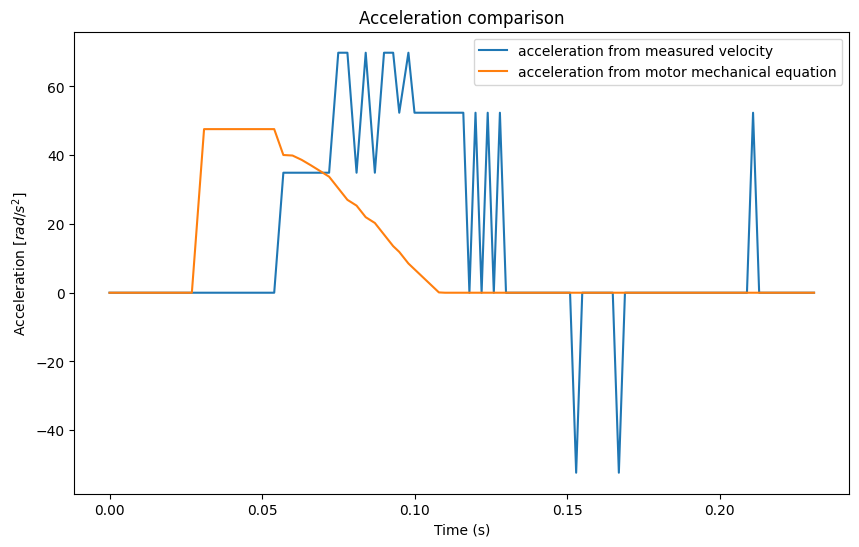

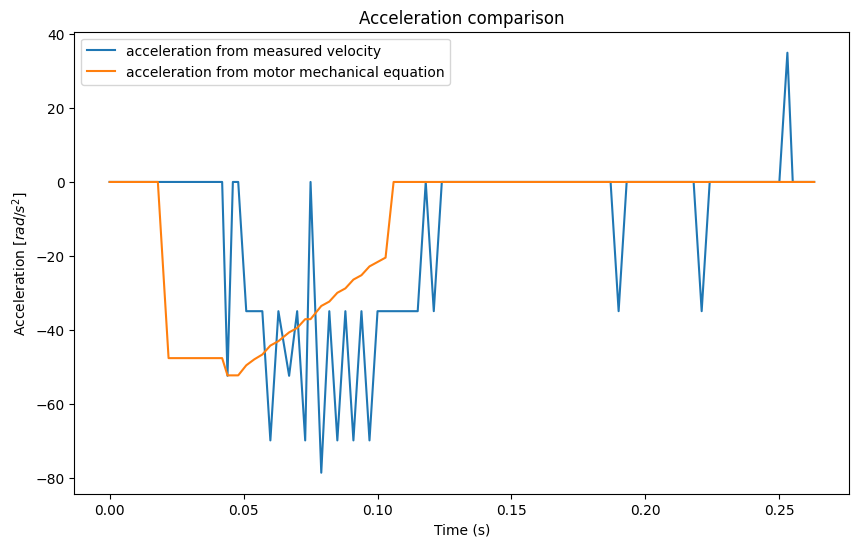

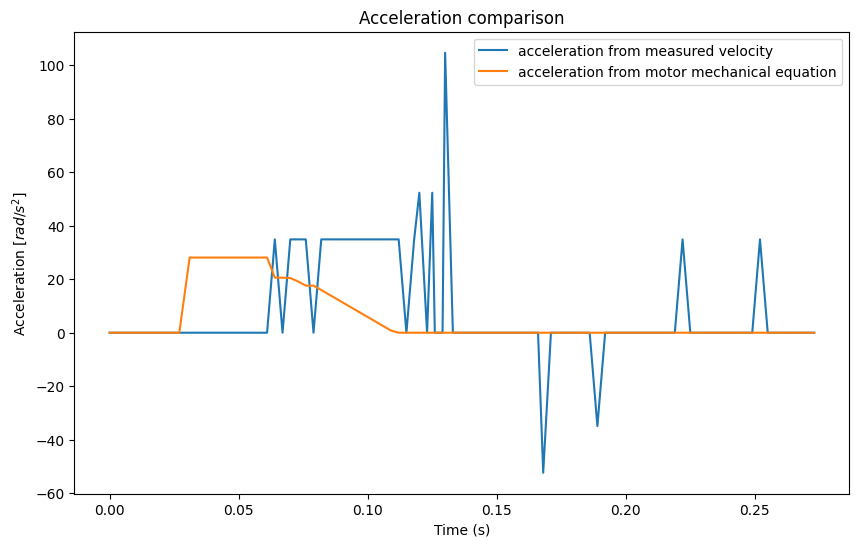

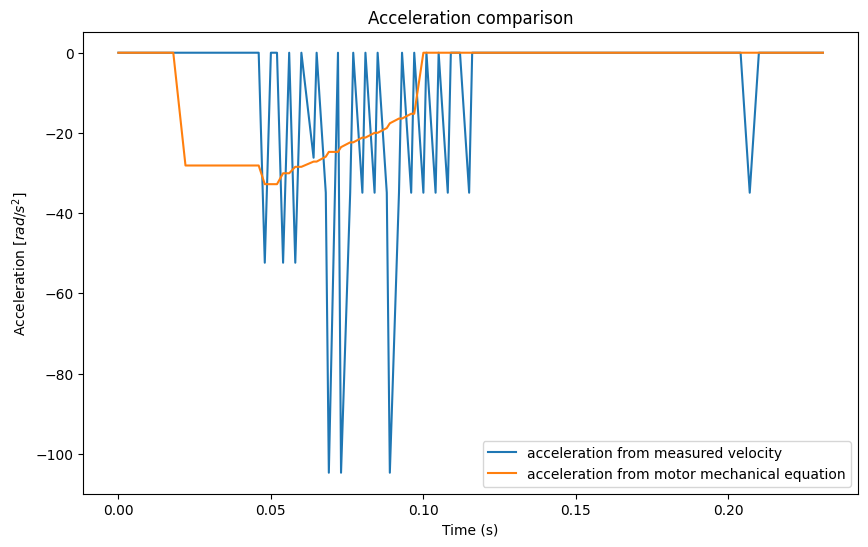

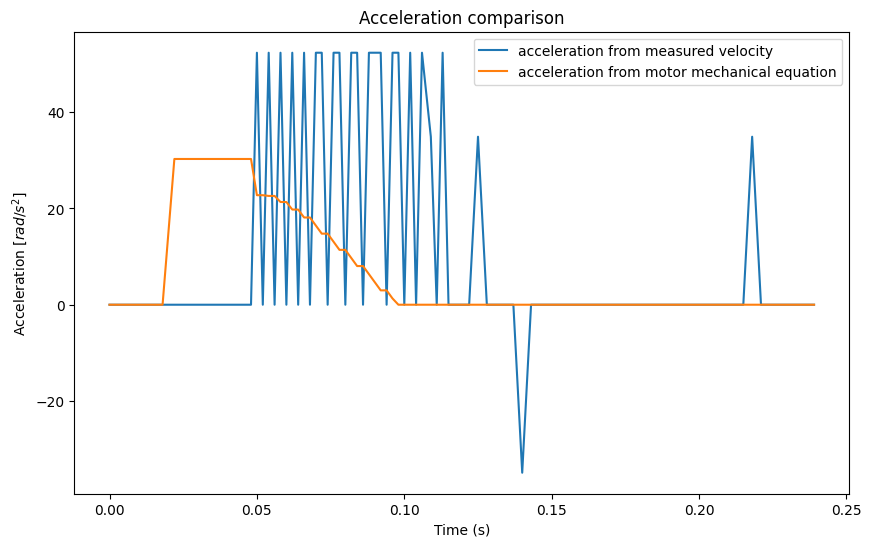

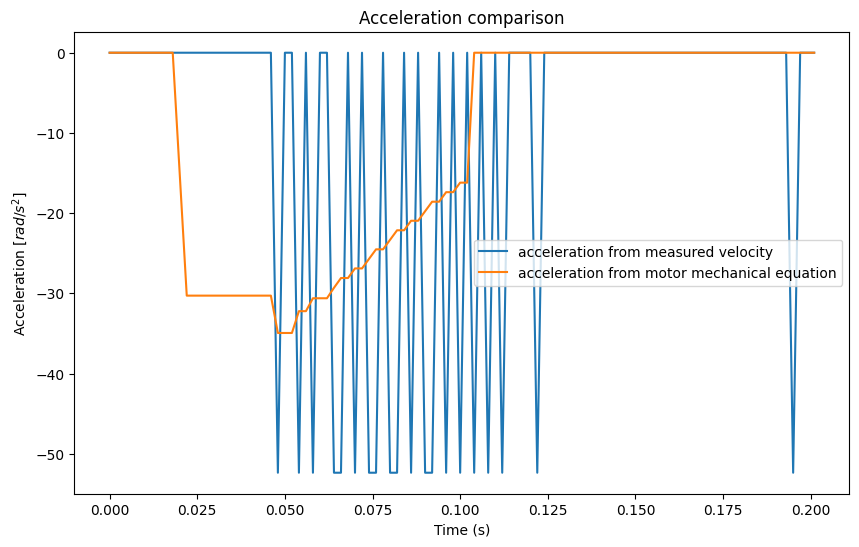

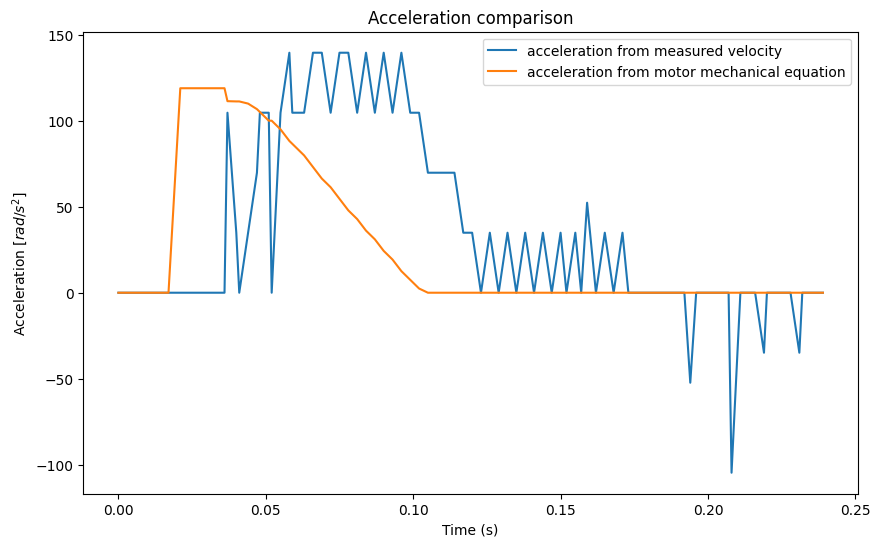

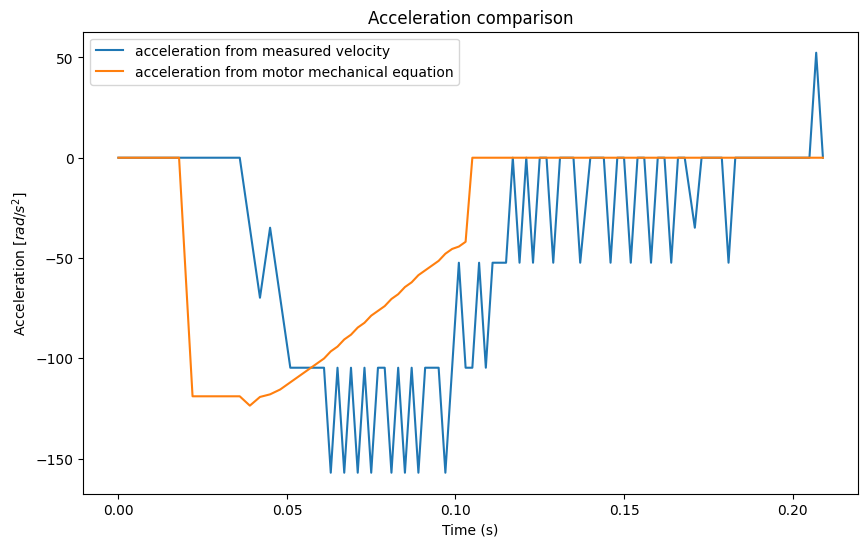

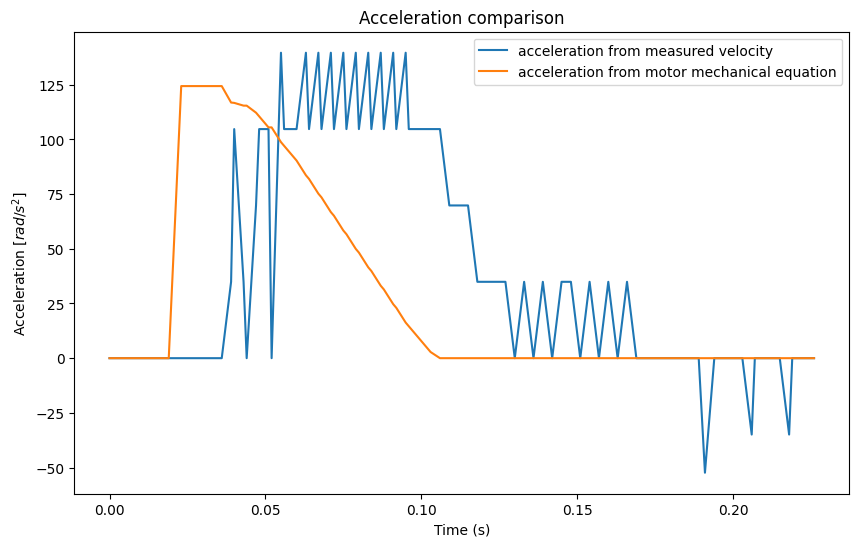

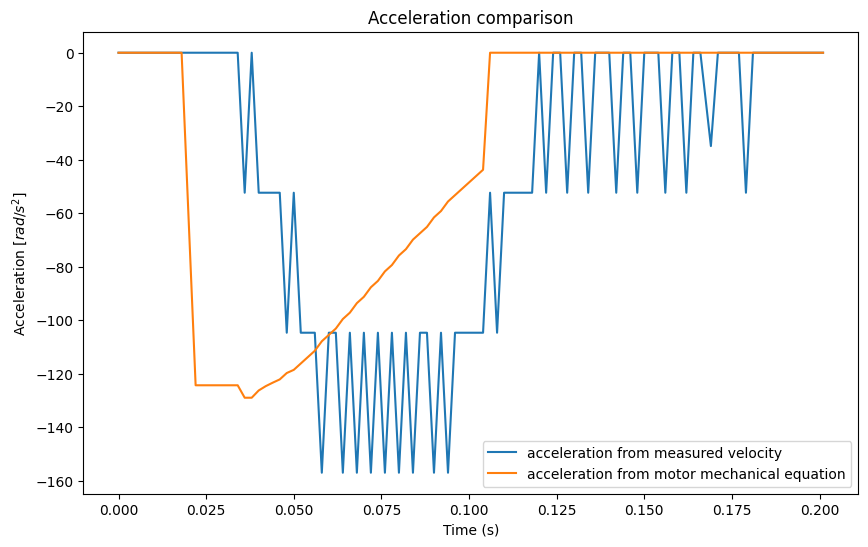

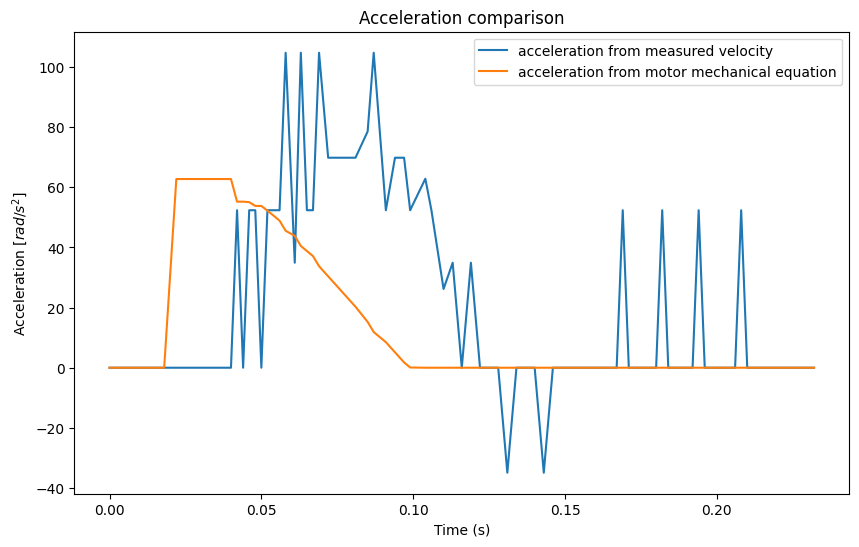

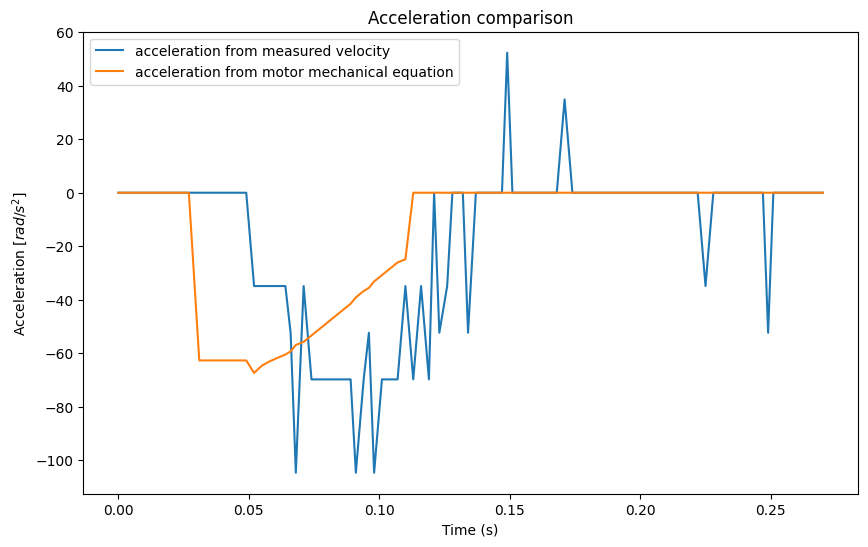

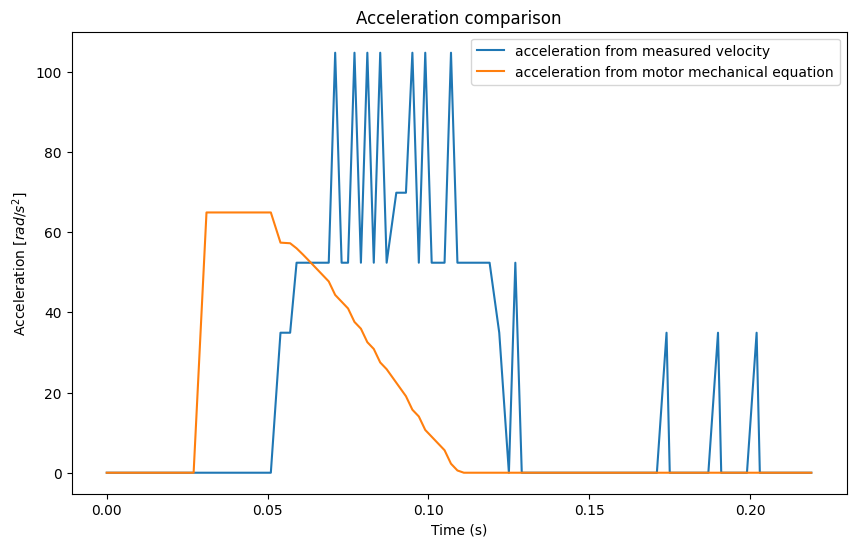

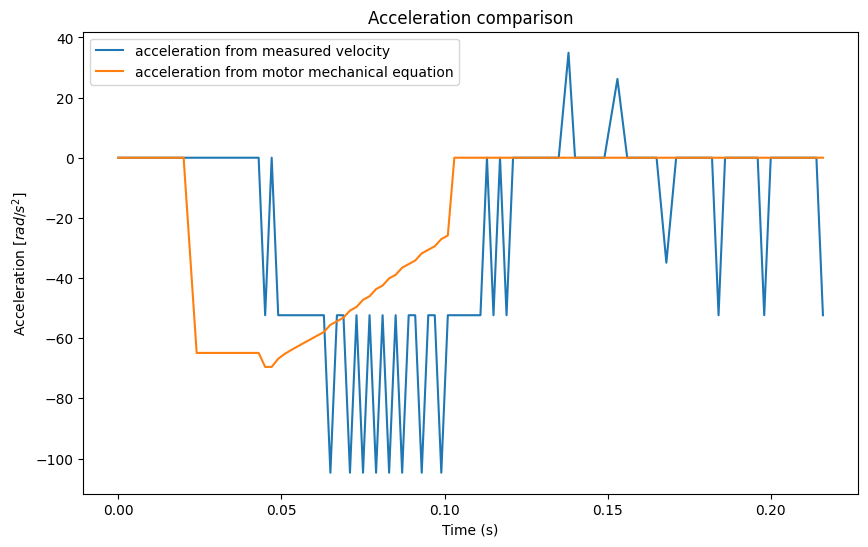

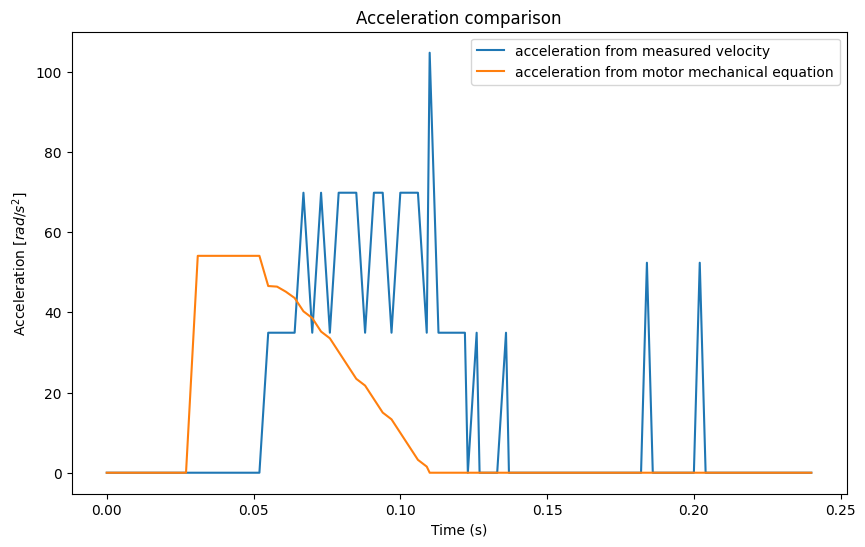

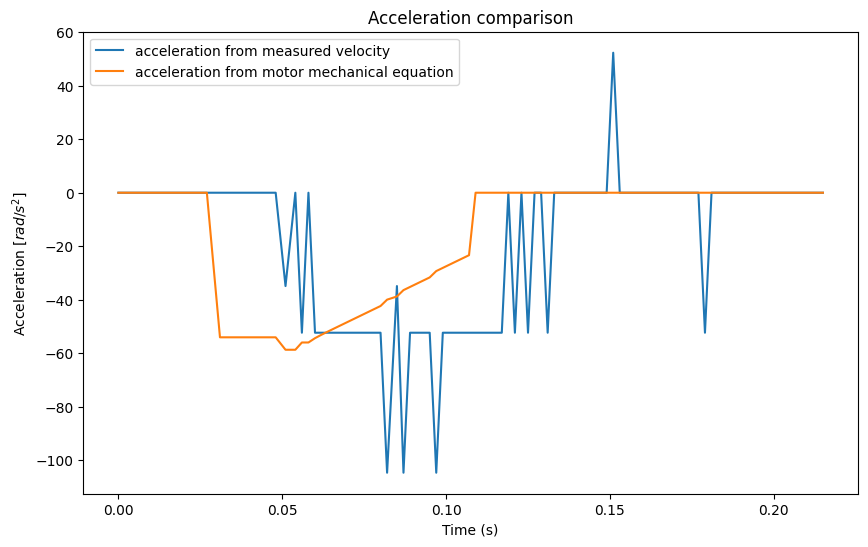

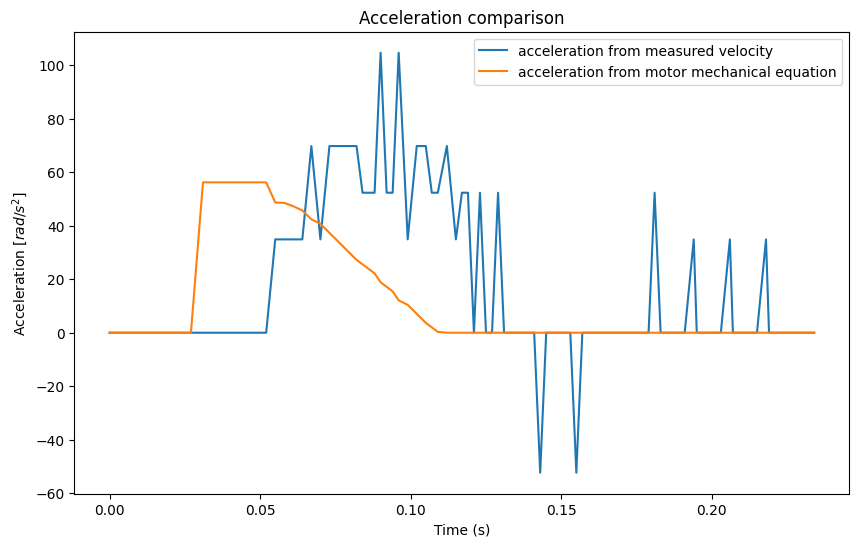

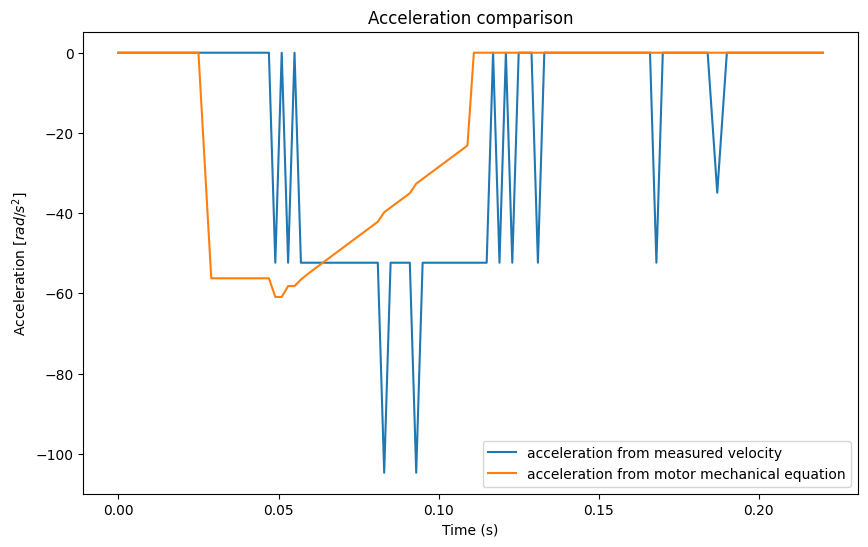

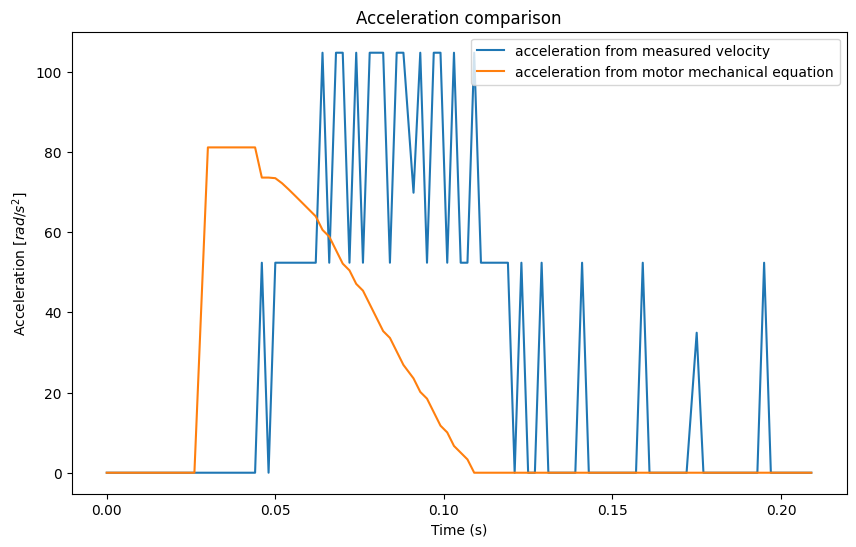

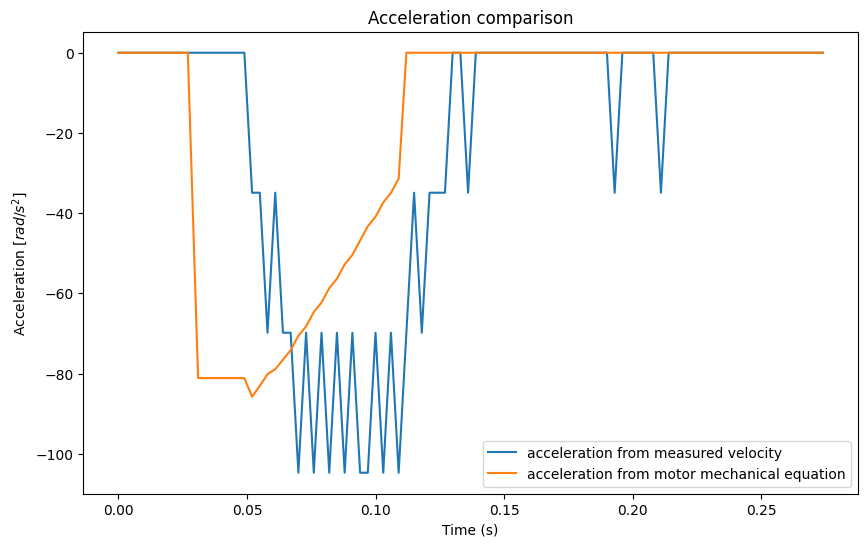

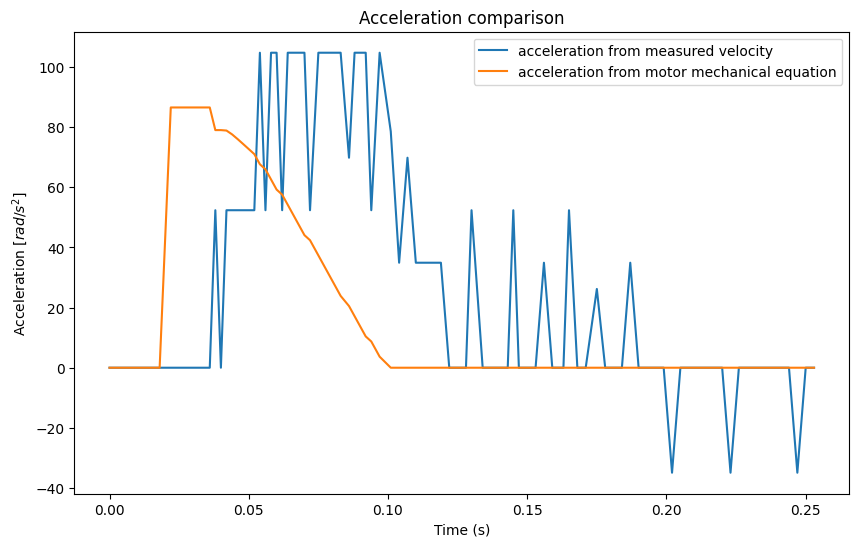

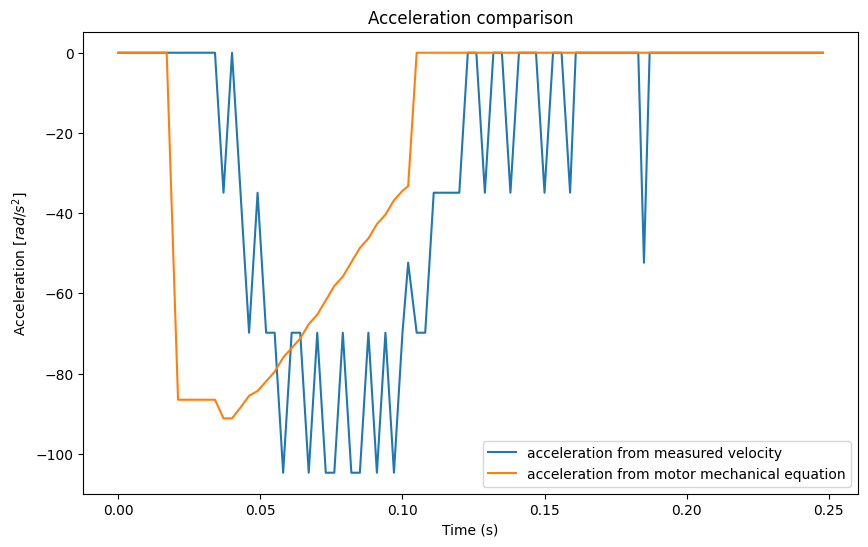

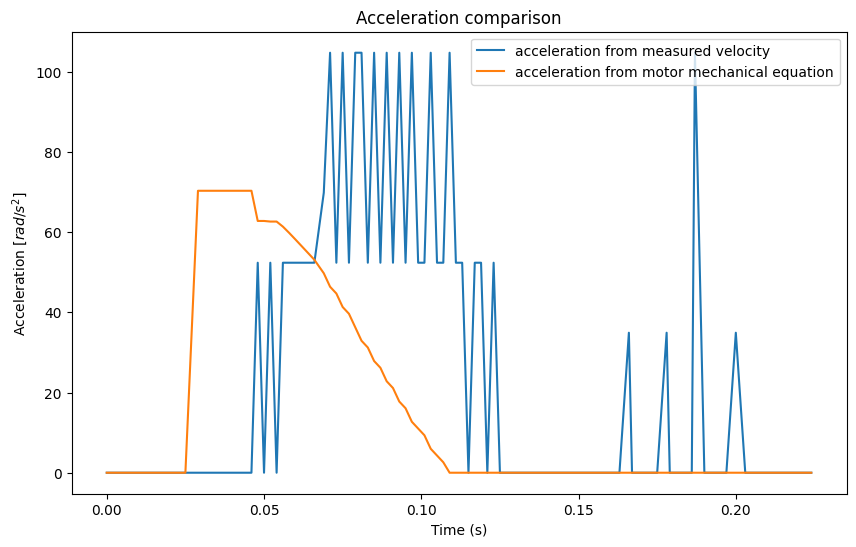

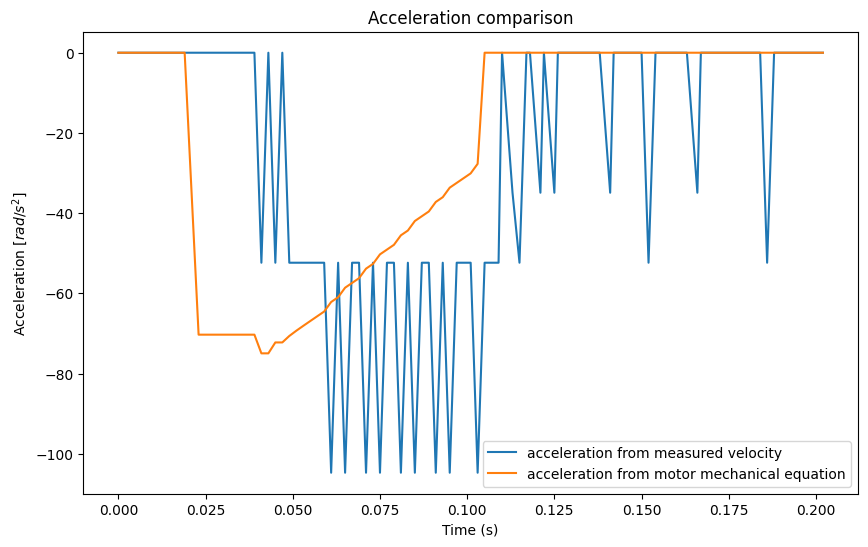

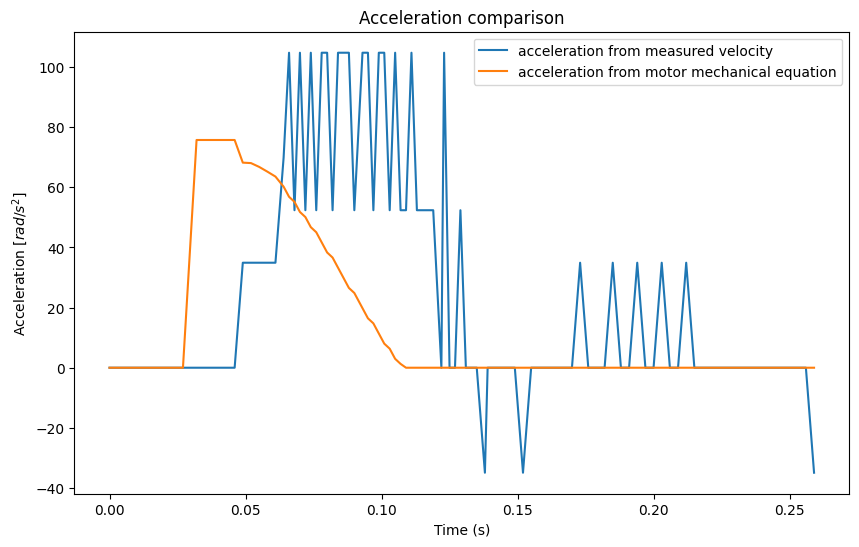

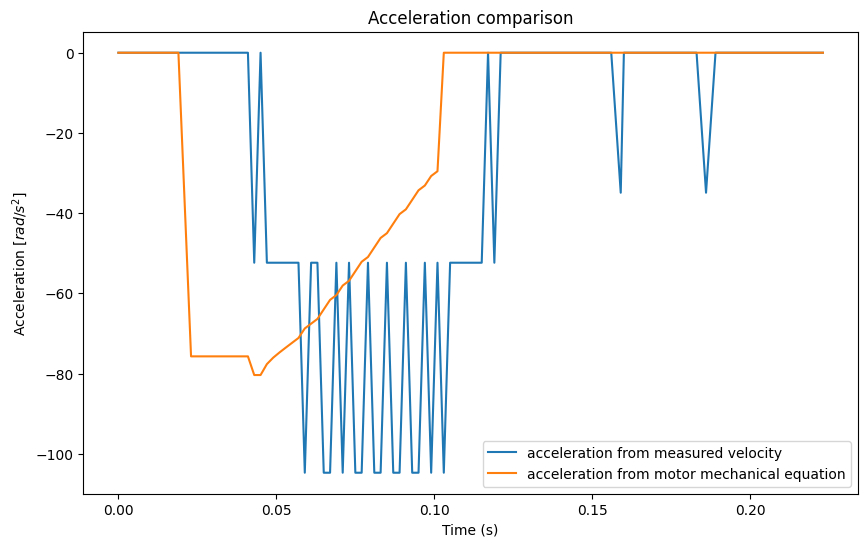

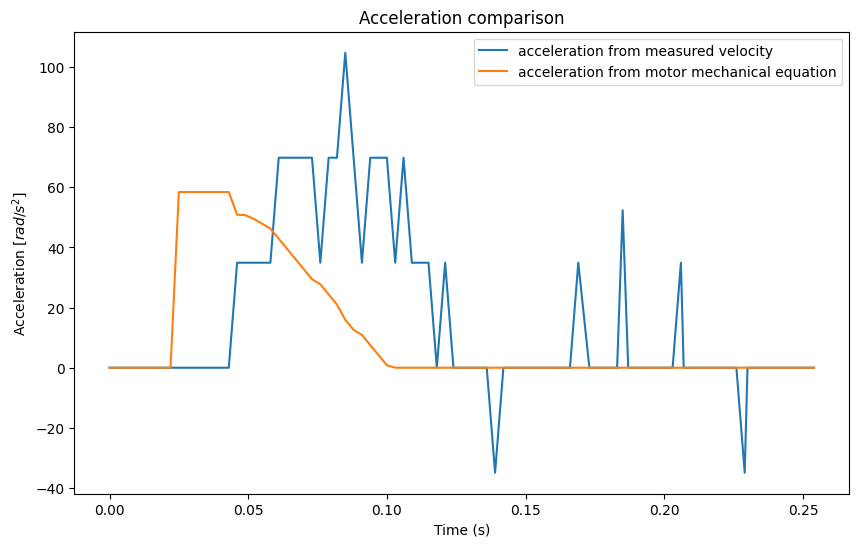

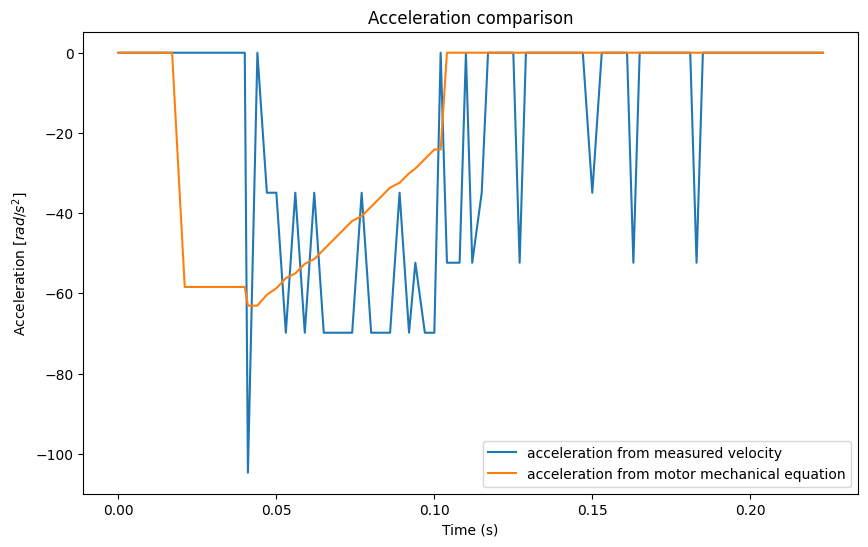

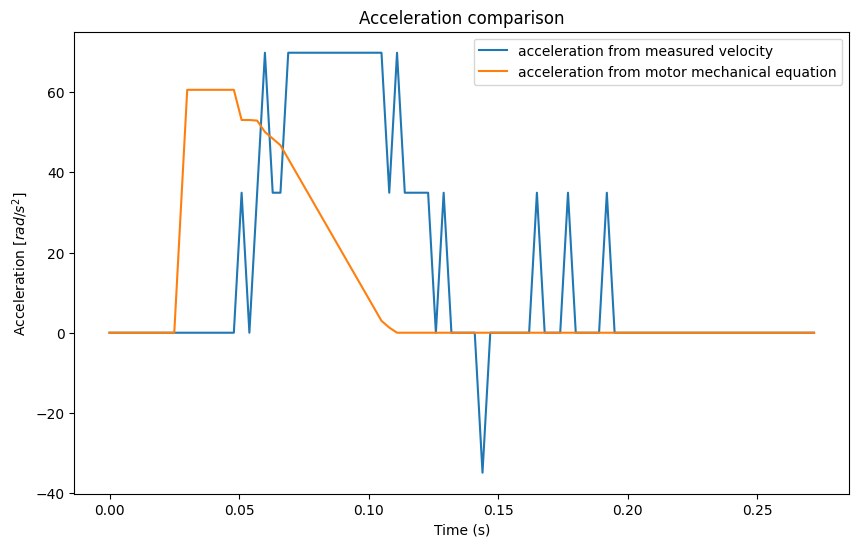

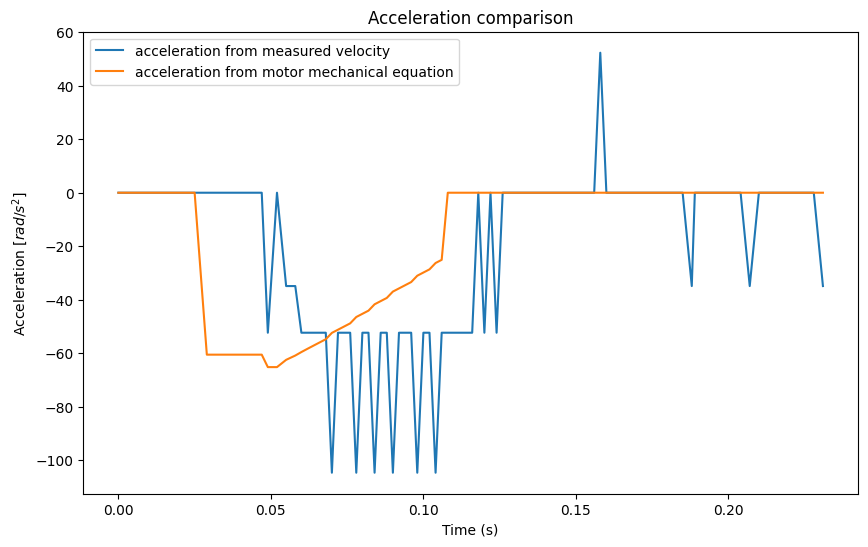

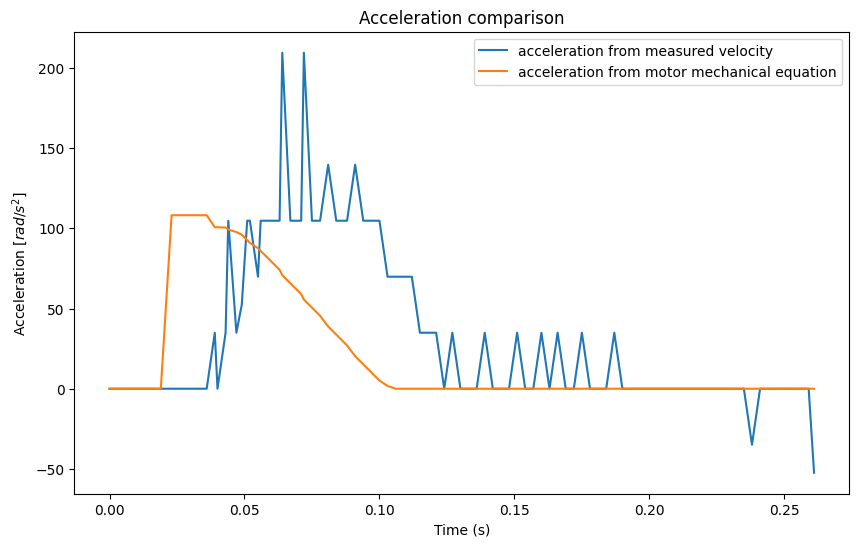

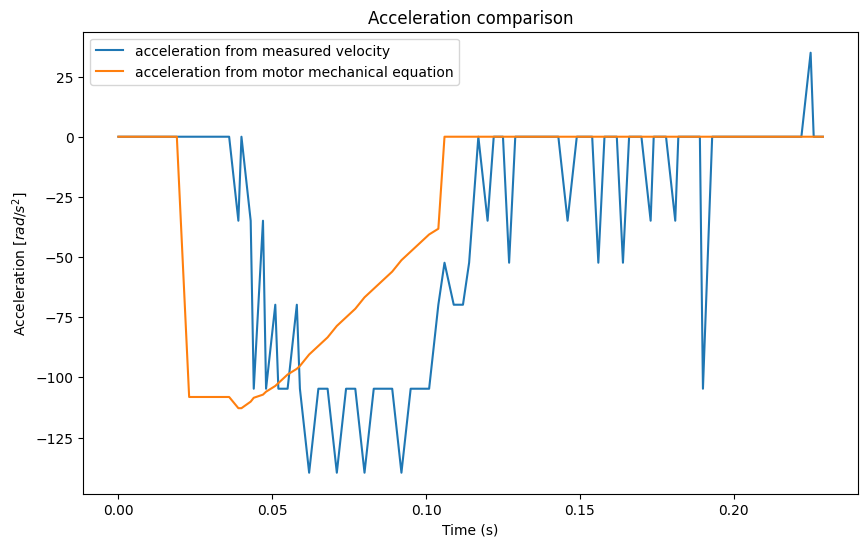

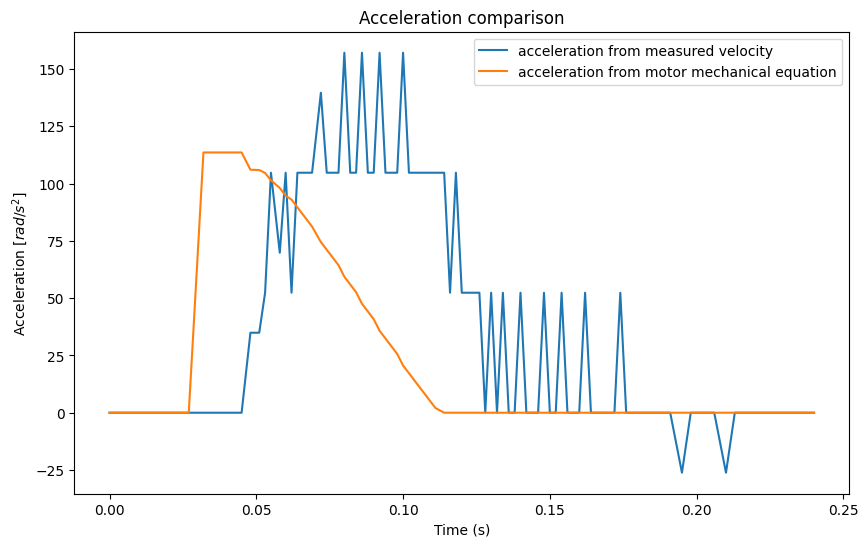

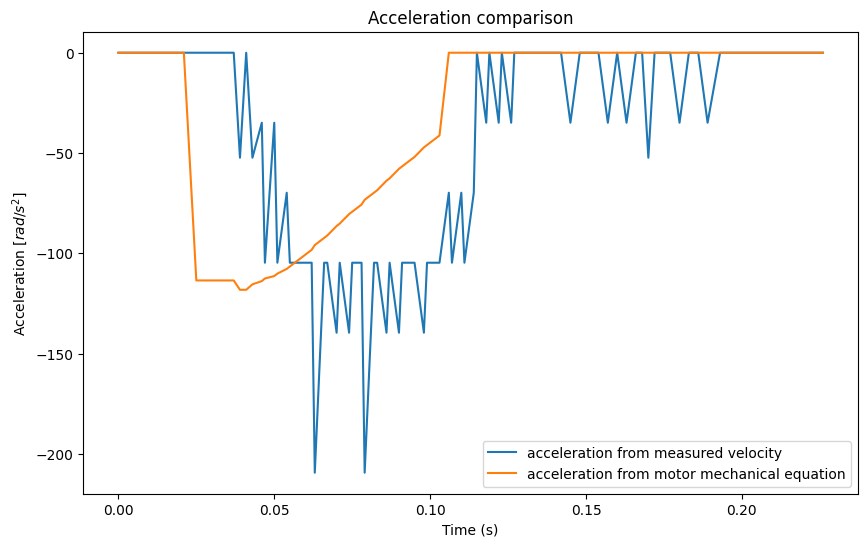

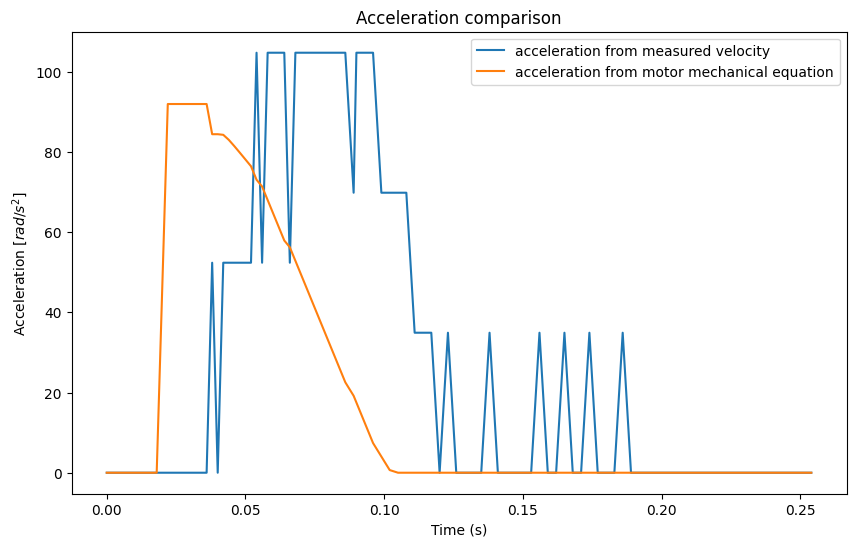

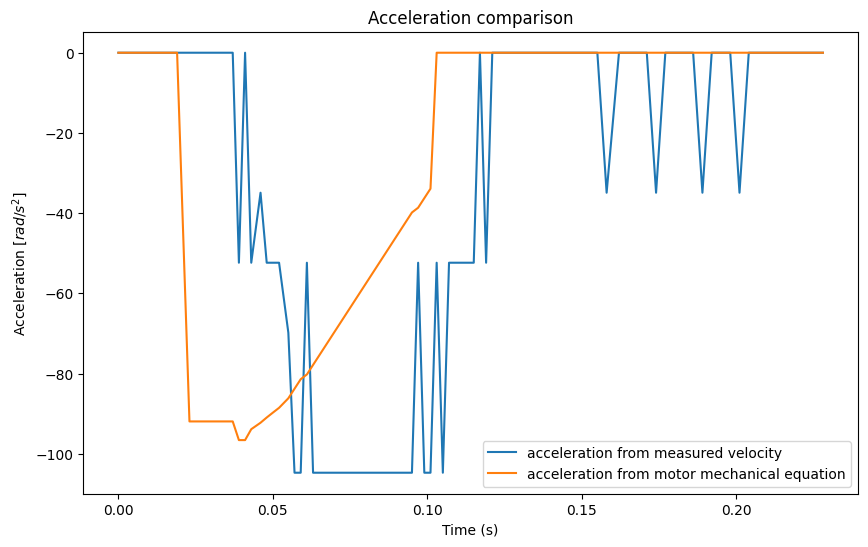

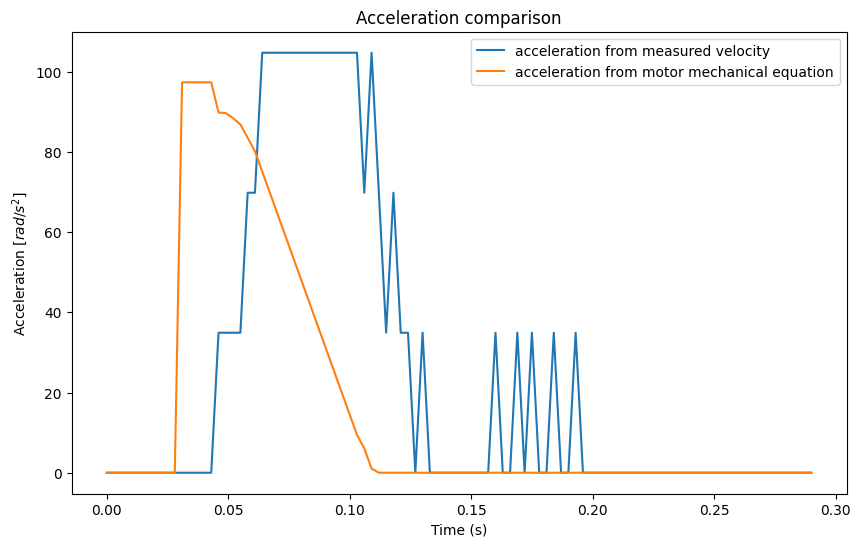

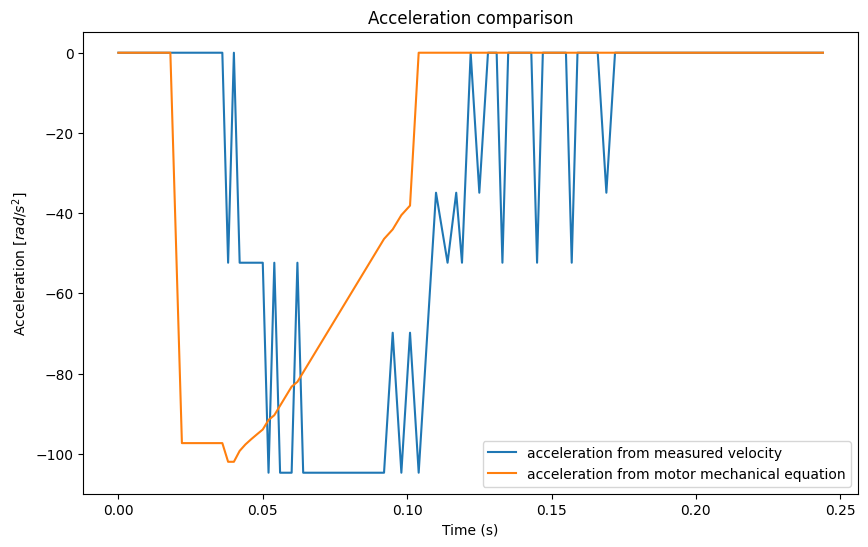

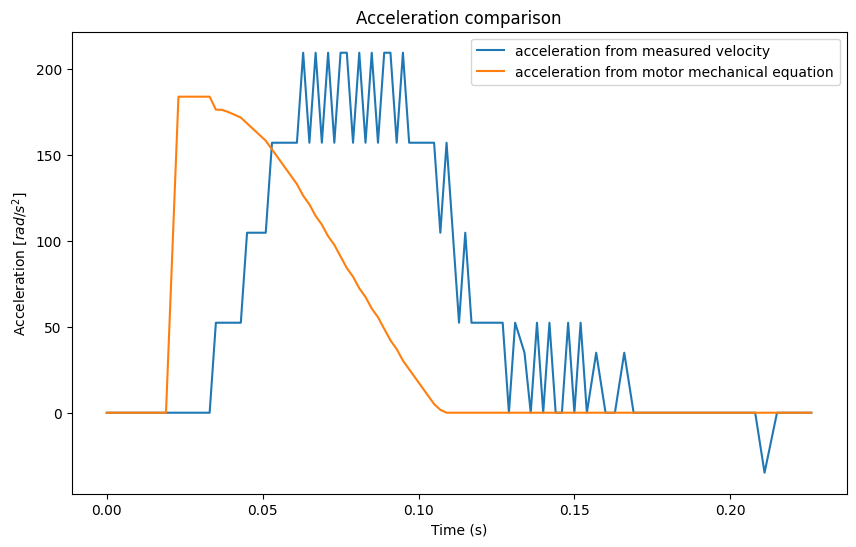

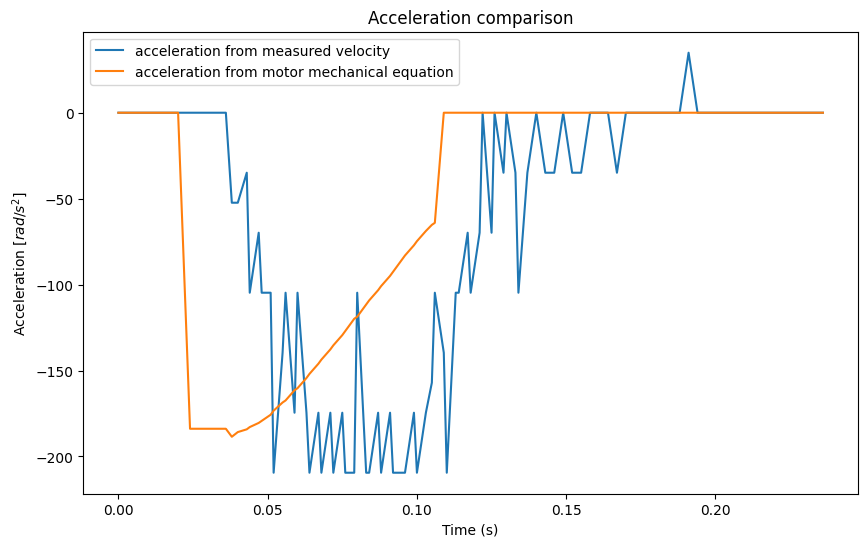

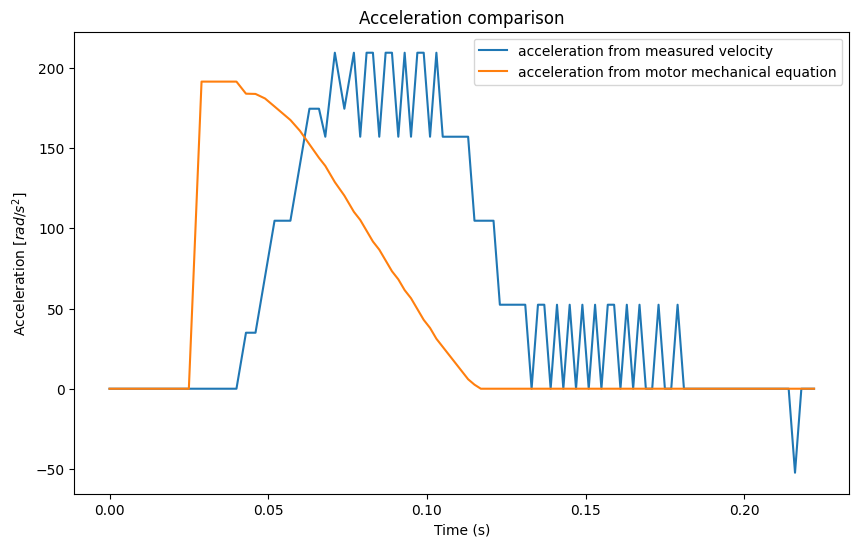

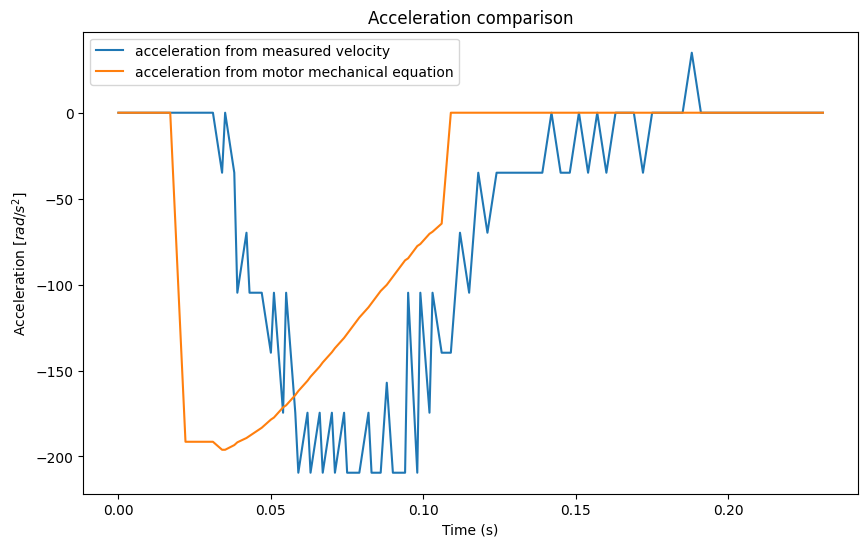

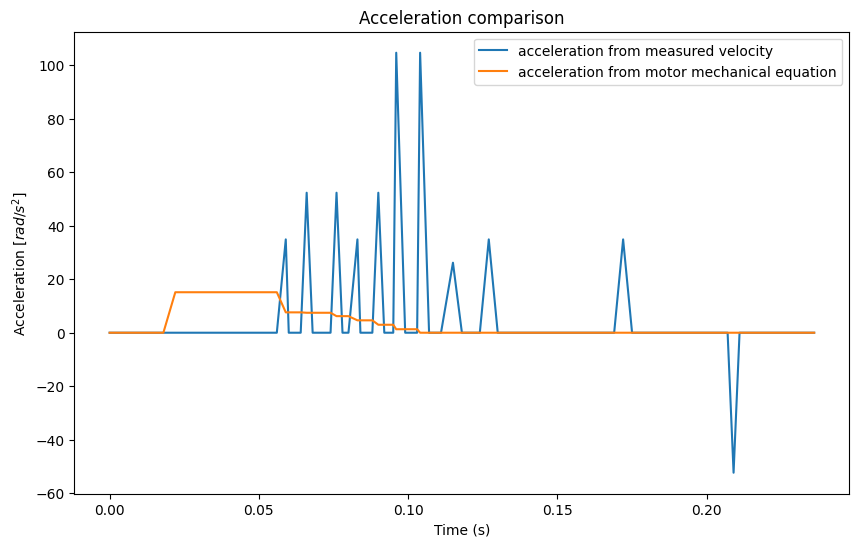

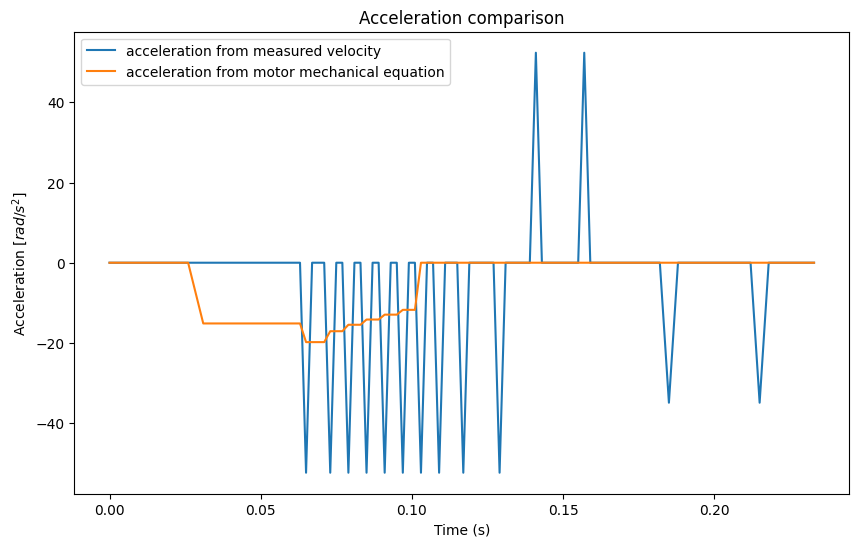

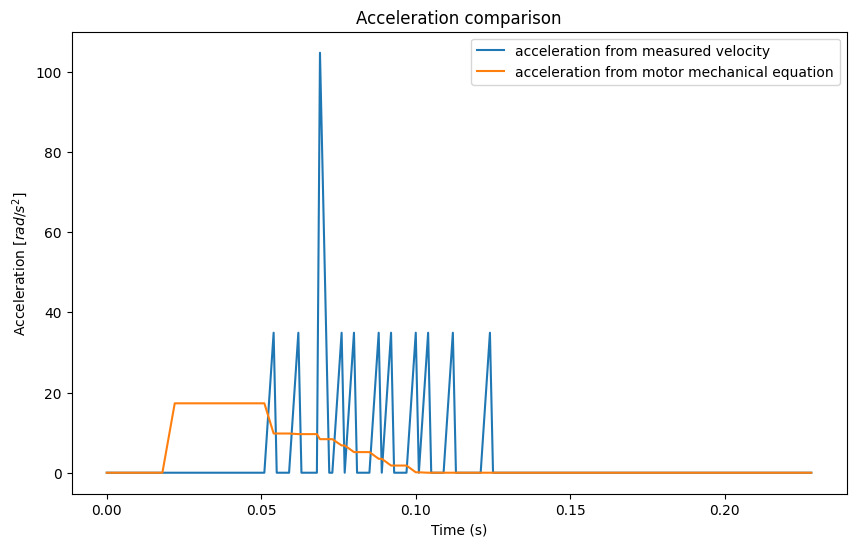

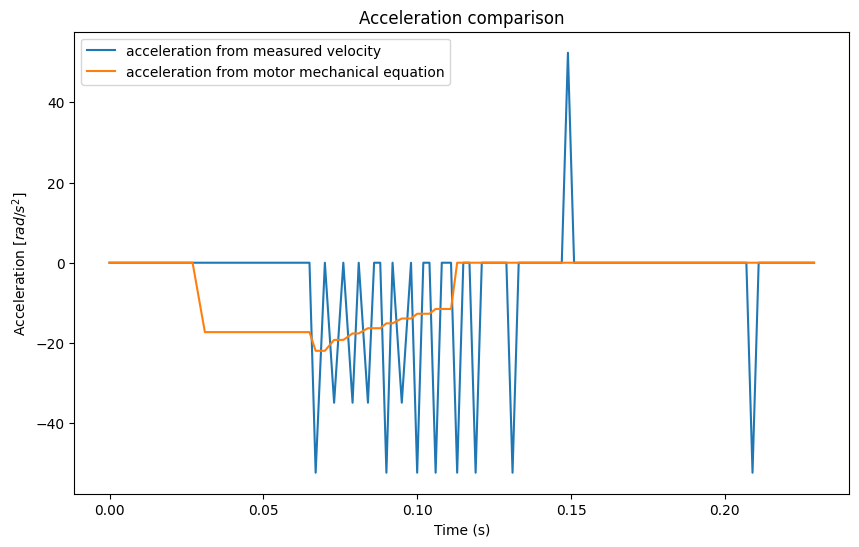

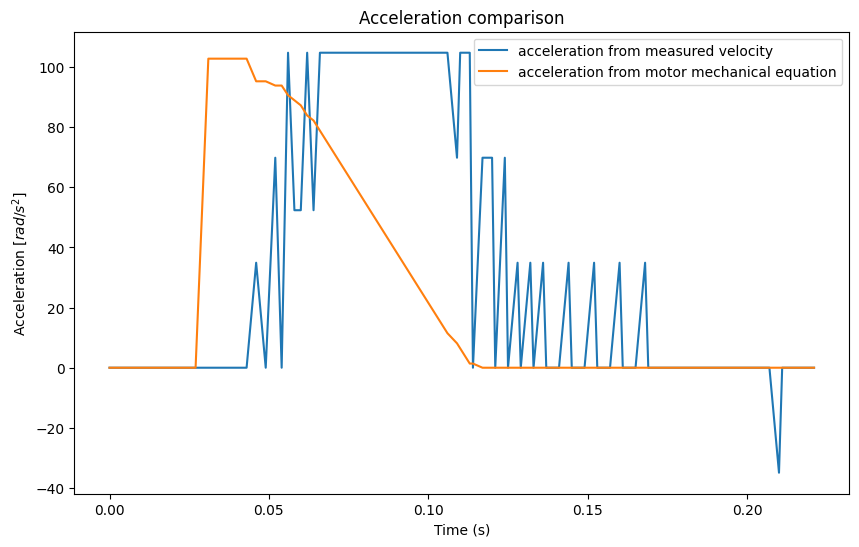

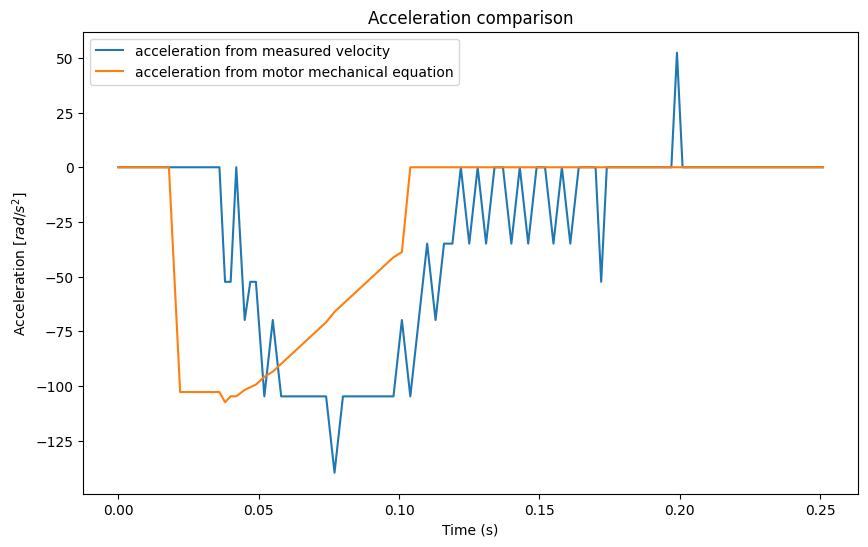

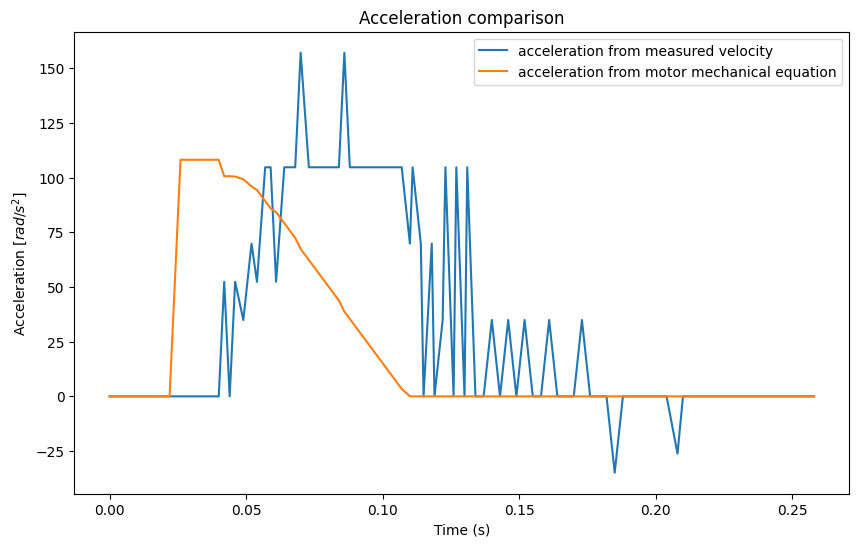

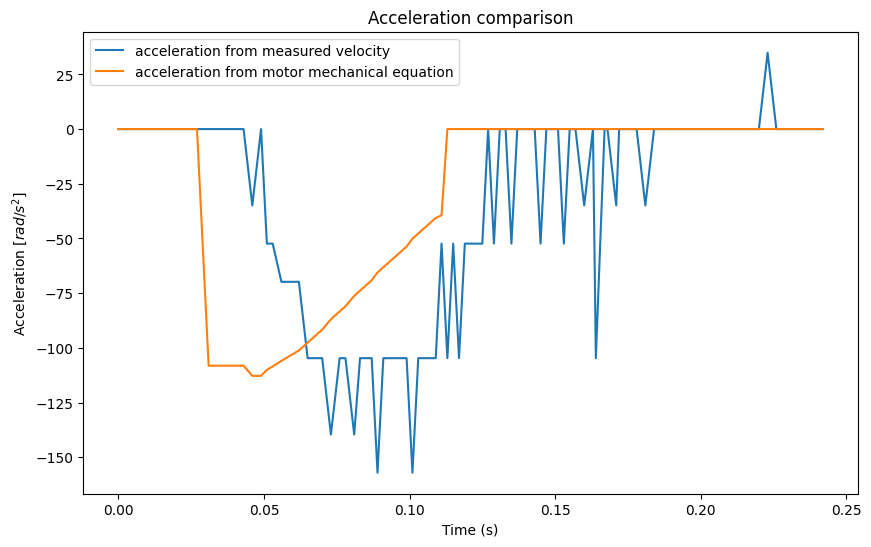

In [28]:
from src.modelisation import friction_torque


for df in new_dfs:
    parameters_to_find = kt, Ra, 0.080964165, 0.0665140867408596, 0.203719639, 0.04217117990939209, 0.0155818308
    friction_torque(df, parameters_to_find)
    df['tau_o'] = np.where(
        df['DXL_Velocity'] == 0,
        np.where(
            np.abs(df['tau_f']) >= np.abs(df['tau']),
            0,
            df['tau'] - np.sign(df['tau']) * df['tau_f']
        ),
        np.where(
            (df['tau'] * df['DXL_Velocity'] > 0) & (np.abs(df['tau_f']) < np.abs(df['tau'])),
            df['tau'] - np.sign(df['tau']) * df['tau_f'],
            0
        )
    )
    df['a'] = (df['tau_o']) /( 0.0155818308 + external_inertia)
    # Filter the dataframe for rows where acceleration is not zero
    acceleration_periods = df[df['a'] != 0]

    # Sum the 'delta_t' column of the filtered dataframe
    total_delta_t_acc = acceleration_periods['delta_t'].sum()
    plt.figure(figsize=(10, 6))
    plt.plot(df['t'][:100]-df['t'][0], df['Acceleration_from_DXL_Velocity'][:100], label='acceleration from measured velocity')
    # plt.plot(df['DXL_Velocity'][100:], label='acceleration')
    plt.plot(df['t'][:100]-df['t'][0], df['a'][:100], label='acceleration from motor mechanical equation')
    plt.xlabel('Time (s)')
    plt.ylabel(r'Acceleration [$rad/s^2$]')
    plt.title(f'Acceleration comparison')
    plt.legend()
    plt.show()